# Assessment of Tree Detection, Classification, and Geolocation Model
# Density Experiment - Match Predicted Trees to Tree Inventories and Compute RMSE Between Matches

Thomas Lake & Brit Laginhas, December 2024


In [2]:
# Imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

# Geospatial Analysis
import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point, box
from shapely.ops import nearest_points

# Spatial Analysis
from scipy.spatial import cKDTree
from scipy import stats
from scipy.optimize import curve_fit, OptimizeWarning

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import contextily as ctx
import cartopy.crs as ccrs

# Statistical Analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import mean_squared_error

# Logging and Warnings
import logging
import warnings

# Configure Matplotlib
%matplotlib inline


# Load datasets: Geolocated trees, Panoramic images, Inventory Trees, and Sampling Grids

In [121]:
# Define city for analyses
city = "Buffalo"

In [122]:
# Import .CSV File for Geolocated Trees from Model
#geolocated_trees = f"C:/Users/talake2/Desktop/tree-geolocation-exp/{city}_geolocation/tree_geolocation_filtered_results_{city}.csv"
geolocated_trees = f"/Users/spwitz/Desktop/tree-geolocation-exp/{city}_geolocation/tree_geolocation_filtered_results_{city}.csv"

geolocated_trees = pd.read_csv(geolocated_trees)

# Convert geolocated trees into a geodataframe
geometry = [Point(xy) for xy in zip(geolocated_trees['longitude'],  geolocated_trees['latitude'])]
geolocated_trees_gdf = gpd.GeoDataFrame(geolocated_trees, geometry=geometry, crs="EPSG:4326")

# Print the first 5 rows of the geolocated trees geodataframe
geolocated_trees_gdf.head()


,Intersection,Pano_ID_1,Pano_Origin_Lon_1,Pano_Origin_Lat_1,Est_Depth_1,Pano_ID_2,Pano_Origin_Lon_2,Pano_Origin_Lat_2,Est_Depth_2,abies_prob,...,triadica_prob,tristaniopsis_prob,tsuga_prob,ulmus_prob,washingtonia_prob,zelkova_prob,geometry,predicted_genus,latitude,longitude
0,POINT (-78.80547773435377 42.868780149301976),-0d5jjuAgMNGep3ze9qhBw,-78.805514,42.868689,11.685827,OtmlE7dc5luo55q5oaYAjw,-78.821315,42.834797,13.757795,0.001131,...,0.063864,0.001466,0.000419,0.017870,0.001264,0.003944,POINT (-78.80548 42.86878),pyrus,42.868780,-78.805478
1,POINT (-78.80534070510075 42.86872767301434),-0d5jjuAgMNGep3ze9qhBw,-78.805514,42.868689,16.597894,PmGPFRexgzDbSRxRW_0emA,-78.806763,42.852860,16.030681,0.001014,...,0.000059,0.000347,0.000521,0.000438,0.002600,0.000060,POINT (-78.80534 42.86873),acer,42.868728,-78.805341
2,POINT (-78.80534653269049 42.86872637166818),-0d5jjuAgMNGep3ze9qhBw,-78.805514,42.868689,16.597894,XWUFs2sdiAJsWNF3A7GEeg,-78.807331,42.832581,9.143955,0.000270,...,0.000281,0.000454,0.000196,0.002229,0.000290,0.000753,POINT (-78.80535 42.86873),acer,42.868726,-78.805347
3,POINT (-78.80534312528266 42.868640870838114),-0d5jjuAgMNGep3ze9qhBw,-78.805514,42.868689,16.658601,PmGPFRexgzDbSRxRW_0emA,-78.806763,42.852860,16.146164,0.000349,...,0.000494,0.000143,0.000294,0.006702,0.001168,0.421615,POINT (-78.80534 42.86864),acer,42.868641,-78.805343
4,POINT (-78.8118868933076 42.843625170149544),-2EQMgrmKgma6nX_L_QMLg,-78.811921,42.843567,8.864377,mYIyP1gL3hn0kwUxx4pMzQ,-78.826290,42.851935,10.927355,0.000266,...,0.000510,0.000262,0.000193,0.000970,0.000233,0.000199,POINT (-78.81189 42.84363),crataegus,42.843625,-78.811887


### Importing and Preparing Panoramic Image Data for Geospatial Analysis


In [123]:
# Import .CSV File for Panoramic Image Locations from 'initial geolocation' file
panos = f"/Users/spwitz/Desktop/tree-geolocation-exp/{city}_geolocation/tree_geolocation_initial_results_{city}.csv"
panos = pd.read_csv(panos, on_bad_lines='skip')


# Define the bounding box of panoramic images for analysis
bbox = [
    panos['Pano_Origin_Lon'].min() - 0.0003,
    panos['Pano_Origin_Lon'].max() + 0.0003,
    panos['Pano_Origin_Lat'].min() - 0.0003, 
    panos['Pano_Origin_Lat'].max() + 0.0003
]

# Convert panos into a GeoDataFrame
geometry = [Point(xy) for xy in zip(panos['Pano_Origin_Lon'],  panos['Pano_Origin_Lat'])]
panos_gdf = gpd.GeoDataFrame(panos, geometry=geometry, crs="EPSG:4326")

# Display the GeoDataFrame
print(panos_gdf.head())

# Print length of rows
print(len(panos_gdf))

                  Pano_ID  Pano_Origin_Lon  Pano_Origin_Lat  Est_Tree_Lon  \
0  -0d5jjuAgMNGep3ze9qhBw       -78.805514        42.868689    -78.805474   
1  -0d5jjuAgMNGep3ze9qhBw       -78.805514        42.868689    -78.805319   
2  -0d5jjuAgMNGep3ze9qhBw       -78.805514        42.868689    -78.805323   
3  -2EQMgrmKgma6nX_L_QMLg       -78.811921        42.843567    -78.811878   
4  -2EQMgrmKgma6nX_L_QMLg       -78.811921        42.843567    -78.811775   

   Est_Tree_Lat Predicted_Genus  Pano_Tree_Angle  Est_Depth     Bbox_Area  \
0     42.868790           pyrus        16.285063  11.685827  4.620794e+06   
1     42.868732            acer        73.054703  16.597894  3.157076e+06   
2     42.868635            acer       110.995070  16.658601  2.407939e+06   
3     42.843640       crataegus        23.383610   8.864377  1.292896e+07   
4     42.843536            acer       106.213039  12.425506  2.431030e+06   

   Bbox_Aspect  ...  taxus_prob  thuja_prob  tilia_prob  triadica_prob  \


### Importing and Filtering Tree Inventory Data for Analysis


In [124]:

# Import .CSV File for Tree Inventory from Autoarborist filtered by the density sampling grids
inventory_trees = f"/Users/spwitz/Desktop/tree-geolocation-exp/sampled_density_grids_autoarborist_join_inventory_cities/aa_allgenera/{city}_aa_allgenera_merged_w_sampledgrids.csv"
tree_inventory = pd.read_csv(inventory_trees)

# Convert tree_inventory to a geodataframe
geometry = [Point(xy) for xy in zip(tree_inventory['longitude'],  tree_inventory['latitude'])]
tree_inventory_gdf = gpd.GeoDataFrame(tree_inventory, geometry=geometry, crs="EPSG:4326")

# Subset tree_inventory by the bounding box
#xmin, xmax, ymin, ymax = bbox
#tree_inventory_gdf = tree_inventory_gdf.cx[xmin:xmax, ymin:ymax]

#drop_cols = ['genus label', 'capture time street img', 'tree center x street img', 'tree center y street img']
#tree_inventory_gdf = tree_inventory_gdf.drop(columns = drop_cols)

# Output basic summary statistics of dataset
print(f'There are {tree_inventory_gdf.shape[0]} trees in the {city} inventory and {geolocated_trees_gdf.shape[0]} predicted trees')
tree_inventory_gdf.head()


There are 1142 trees in the Buffalo inventory and 4223 predicted trees


,index,idx,shape_lng,shape_lat,genus,taxonomy_id,location,type,tree id,tree location idx,...,genus label,capture time street img,tree center x street img,tree center y street img,id.y,test_tree_count,full_tree_count,density_level,grid_id,geometry
0,17423,47e1294d-03ad-33fc-bcf0-d0d6b2848cde,-78.864916,42.888389,aesculus,6,Buffalo,train,11093878980407815945,47e1294d-03ad-33fc-bcf0-d0d6b2848cde,...,6,October 2020,479,576,1204,2,9,Medium Density,39,POINT (-78.86491 42.88839)
1,32531,25210f28-45d5-3bf2-ae7b-194ab80b78b5,-78.865024,42.888467,tilia,303,Buffalo,train,15729222936769559765,25210f28-45d5-3bf2-ae7b-194ab80b78b5,...,303,October 2020,295,576,7606,2,9,Medium Density,39,POINT (-78.86502 42.88847)
2,48269,eba0475b-4de7-3795-9778-941ca8ce0d92,-78.869651,42.888225,tilia,303,Buffalo,train,13763543893469697137,eba0475b-4de7-3795-9778-941ca8ce0d92,...,303,October 2020,297,576,13956,5,13,High Density,86,POINT (-78.86965 42.88823)
3,50327,b80d4990-41d4-363e-9664-68defe321f1d,-78.865145,42.888443,tilia,303,Buffalo,train,1581106535798691320,b80d4990-41d4-363e-9664-68defe321f1d,...,303,October 2020,434,576,14809,2,9,Medium Density,39,POINT (-78.86514 42.88844)
4,67999,62d055cb-0604-30f3-9636-2190b79d829b,-78.864721,42.888078,acer,4,Buffalo,train,1119896401972110320,62d055cb-0604-30f3-9636-2190b79d829b,...,4,October 2020,417,576,22815,2,9,Medium Density,39,POINT (-78.86472 42.88808)


### Importing and Analyzing Sampled City Grids for Tree Inventories


In [125]:
# Import City Grid Polygons Sampled for Tree Inventories Based on Density Quantiles
sampled_grids = f"/Users/spwitz/Desktop/tree-geolocation-exp/output_grids_sampled_tree_inventories_density/sampled_grids/{city}_sampled_grid.geojson"

# Read the GeoJSON file with sampled grids
sampled_grids_gdf = gpd.read_file(sampled_grids)

# Convert to EPSG 4326 CRS
sampled_grids_gdf = sampled_grids_gdf.to_crs("EPSG:4326")

# Check the first few rows of the GeoDataFrame
print(sampled_grids_gdf.tail())

# Get information on one sampled grid
#sampled_grids_gdf.iloc[0]
sampled_grids_gdf.iloc[0].geometry.bounds


     test_tree_count  full_tree_count density_level  \
103                5               22  High Density   
104               11               28  High Density   
105                7               14  High Density   
106               10               19  High Density   
107               10               20  High Density   

                                              geometry  
103  POLYGON ((-78.82775 42.84814, -78.82752 42.849...  
104  POLYGON ((-78.8647 42.88033, -78.86448 42.8812...  
105  POLYGON ((-78.80664 42.83259, -78.80642 42.833...  
106  POLYGON ((-78.80568 42.88615, -78.80546 42.887...  
107  POLYGON ((-78.80585 42.84068, -78.80563 42.841...  


(-78.81571805781492, 42.87094202986511, -78.81428584567155, 42.87198339568041)

### Plot Geolocated Trees, Panoramic Images, Tree Inventory, and Sampled Grids

/var/folders/82/jx7zyf8d119dh021bmb9ks4w0000gn/T/ipykernel_5315/1794993396.py:47: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


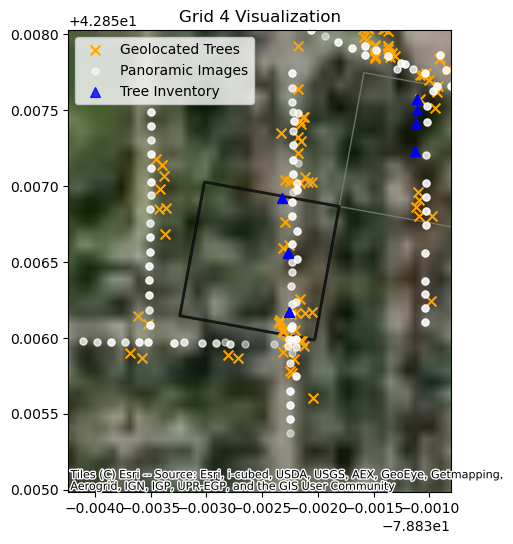

In [126]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import contextily as ctx

# Define the grid index
grid_index = 4

# Extract the specific grid
grid = sampled_grids_gdf.iloc[grid_index]

# Get the bounding box of the grid
grid_bbox = grid.geometry.bounds  # (minx, miny, maxx, maxy)
bbox = [
    grid_bbox[0] - 0.001,  # minx with buffer
    grid_bbox[2] + 0.001,  # maxx with buffer
    grid_bbox[1] - 0.001,  # miny with buffer
    grid_bbox[3] + 0.001   # maxy with buffer
]

# Plot the data
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the sampled grids
sampled_grids_gdf.plot(ax=ax, edgecolor='grey', facecolor='none', linewidth=1, alpha=0.8, label="Sampling Grids")

# Highlight the current grid
gpd.GeoSeries([grid.geometry]).plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2, alpha=0.8, label="Current Grid")

# Plot geolocated trees
geolocated_trees_gdf.plot(ax=ax, marker='x', color='orange', alpha=1, markersize=50, label='Geolocated Trees')

# Plot panoramic images
panos_gdf.plot(ax=ax, marker='o', color='white', alpha=0.5, markersize=25, label='Panoramic Images')

# Plot tree inventory
tree_inventory_gdf.plot(ax=ax, marker='^', color='blue', alpha=0.8, markersize=50, label='Tree Inventory')

# Add a basemap with contextily
ctx.add_basemap(ax, crs=sampled_grids_gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery)

# Set extent to the buffered bounding box
ax.set_xlim(bbox[0], bbox[1])
ax.set_ylim(bbox[2], bbox[3])

# Add legend and title
ax.legend()
ax.set_title(f"Grid {grid_index} Visualization")

# Show the plot
plt.show()


# Experiments with Greedy Genus Matching Tree Inventories and Predictions

## Greedy Genus Matching Between Tree Inventory and Geolocated Trees

In [127]:
# Adjusted code to perform nearest neighbor calculations for both matched and unmatched trees
def greedy_genus_matching_with_nn(tree_inventory_gdf, geolocated_trees_gdf, sampled_grids_gdf, max_distance=15):
    """
    Perform genus-prioritized greedy matching and calculate nearest neighbor distances for both matched and unmatched trees.
    Args:
        tree_inventory_gdf (gpd.GeoDataFrame): Ground truth tree locations with 'Genus' column.
        geolocated_trees_gdf (gpd.GeoDataFrame): Predicted tree locations with 'predicted_genus' column.
        sampled_grids_gdf (gpd.GeoDataFrame): Grids defining spatial sampling areas.
        max_distance (float): Maximum distance to consider a match as valid (in meters).
    Returns:
        list of dict: Matching results, including genus matches, distances, and nearest neighbors for all trees.
    """
    results = []

    def calculate_distance(p1, p2):
        return geodesic((p1.y, p1.x), (p2.y, p2.x)).meters

    # Iterate across sampling grids
    for _, grid_row in sampled_grids_gdf.iterrows():
        grid = grid_row.geometry
        grid_density_level = grid_row['density_level']
        
        # Subset tree inventory and predicted tree points by the density grid
        tree_inventory_in_grid = tree_inventory_gdf[tree_inventory_gdf.intersects(grid)]
        geolocated_trees_in_grid = geolocated_trees_gdf[geolocated_trees_gdf.intersects(grid)]
        panos_in_grid = panos_gdf[panos_gdf.intersects(grid)]

        # Skip grid if there are no geolocated trees in this grid
        if geolocated_trees_in_grid.empty:
            continue
        
        matches = []
        unmatched_trees = []
        genus_matches_count = 0
        neighbor_distances = []

        # Iterate across trees in the inventory
        for idx1, tree1 in tree_inventory_in_grid.iterrows():
            genus_match_tree = None
            genus_match_dist = float('inf')

            # Check for genus match within max distance
            for idx2, tree2 in geolocated_trees_in_grid.iterrows():
                dist = calculate_distance(tree1.geometry, tree2.geometry)
                if dist <= max_distance and tree1['genus'] == tree2['predicted_genus']:
                    if dist < genus_match_dist:
                        genus_match_dist = dist
                        genus_match_tree = idx2

            # Record matches and unmatched trees
            if genus_match_tree is not None:
                matches.append((idx1, genus_match_tree))
                geolocated_trees_in_grid = geolocated_trees_in_grid.drop(genus_match_tree)
                genus_matches_count += 1
            else:
                unmatched_trees.append(idx1)

            # Nearest neighbor analysis for this tree
            tree_coords = np.array([point.coords[0] for point in tree_inventory_in_grid.geometry])
            if len(tree_coords) > 1:
                kdtree = cKDTree(tree_coords)
                nn_distances, _ = kdtree.query(tree1.geometry.coords[0], k=len(tree_coords))
                nn_distances = nn_distances[1:] * 111132  # Exclude the tree itself and convert to meters

                neighbor_distances.append({
                    "inventory_tree_idx": idx1,
                    "is_matched": genus_match_tree is not None,
                    "matched_pred_tree_idx": genus_match_tree,
                    "genus_match_dist": None if genus_match_tree is None else genus_match_dist,
                    "genus_name": tree1['genus'],
                    "num_neighbors": len(nn_distances),
                    "neighbor_distances": nn_distances.tolist(),
                    "min_nn_distance": np.min(nn_distances),
                    "max_nn_distance": np.max(nn_distances),
                    "mean_nn_distance": np.mean(nn_distances),
                })


        results.append({
            "grid_id": grid_row.name,
            "grid_density_level": grid_density_level,
            "num_panos": len(np.unique(panos_in_grid['Pano_ID'])),
            "num_inv_trees": len(tree_inventory_in_grid),
            "num_genus_matches": genus_matches_count,
            "matches_idx": matches,
            "unmatched_tree_idx": unmatched_trees,
            "neighbor_distances": neighbor_distances,
        })

    return results

In [128]:
results = greedy_genus_matching_with_nn(tree_inventory_gdf, geolocated_trees_gdf, sampled_grids_gdf, max_distance=15)
# Examine single grid of matching results
results[3]


{'grid_id': 3,
 'grid_density_level': 'Low Density',
 'num_panos': 30,
 'num_inv_trees': 4,
 'num_genus_matches': 0,
 'matches_idx': [],
 'unmatched_tree_idx': [190, 191, 192, 193],
 'neighbor_distances': [{'inventory_tree_idx': 190,
   'is_matched': False,
   'matched_pred_tree_idx': None,
   'genus_match_dist': None,
   'genus_name': 'fraxinus',
   'num_neighbors': 3,
   'neighbor_distances': [0.0, 17.993777436496195, 17.993777436496195],
   'min_nn_distance': np.float64(0.0),
   'max_nn_distance': np.float64(17.993777436496195),
   'mean_nn_distance': np.float64(11.995851624330797)},
  {'inventory_tree_idx': 191,
   'is_matched': False,
   'matched_pred_tree_idx': None,
   'genus_match_dist': None,
   'genus_name': 'zelkova',
   'num_neighbors': 3,
   'neighbor_distances': [0.0, 17.993777436496195, 17.993777436496195],
   'min_nn_distance': np.float64(0.0),
   'max_nn_distance': np.float64(17.993777436496195),
   'mean_nn_distance': np.float64(11.995851624330797)},
  {'inventory_tre

In [129]:
# Create an empty list to hold rows from all grids
all_data_rows = []

# Iterate through all grid results
for grid_result in results:
    for neighbor_info in grid_result['neighbor_distances']:
        # Create a row for each tree's neighbor analysis
        row = {
            'grid_id': grid_result['grid_id'],
            'grid_density_level': grid_result['grid_density_level'],
            'grid_num_panos': grid_result['num_panos'],
            'num_inv_trees': grid_result['num_inv_trees'],
            'num_genus_matches': grid_result['num_genus_matches'],
            'proportion_matches': grid_result['num_genus_matches'] / grid_result['num_inv_trees'],
            'inventory_tree_idx': neighbor_info['inventory_tree_idx'],
            'inventory_genus_name': neighbor_info['genus_name'],
            'is_matched': neighbor_info['is_matched'],
            'match_distance': neighbor_info['genus_match_dist'],
            'matched_pred_tree_idx': neighbor_info['matched_pred_tree_idx'],
            'min_nn_distance': neighbor_info['min_nn_distance'],
            'mean_nn_distance': neighbor_info['mean_nn_distance']
        }
        all_data_rows.append(row)

# Convert the collected rows into a DataFrame
df = pd.DataFrame(all_data_rows)

# Display the DataFrame
#print(df)

# Optionally, save the DataFrame to a CSV for further analysis
df.to_csv(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/datasheets/{city}_tree_greedy_genus_matching_results_dec924.csv', index=False)

### Read in all cities greedy matching and merge into single csv

In [ ]:
# Directory containing the city result files
directory = "/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/datasheets/"

# Initialize an empty list to hold DataFrames
all_city_dataframes = []

# Dictionary to hold the row counts for each city
city_row_counts = {}

# Iterate over all files in the directory
for file_name in os.listdir(directory):
    if file_name.endswith(".csv"):  # Ensure we're only reading CSV files
        # Extract the city name from the file name (assuming consistent naming)
        city_name = file_name.split('_')[0]  # Adjust split logic if needed
        
        # Load the city's data into a DataFrame
        city_df = pd.read_csv(os.path.join(directory, file_name))
        
        # Add a column for the city name
        city_df['city'] = city_name
        
        # Append the DataFrame to the list
        all_city_dataframes.append(city_df)
        
        # Count the number of rows for this city and print
        row_count = len(city_df)
        city_row_counts[city_name] = row_count
        print(f"City: {city_name}, Rows: {row_count}")

# Merge all city DataFrames into a single DataFrame
merged_df = pd.concat(all_city_dataframes, ignore_index=True)

# Count the number of rows per city in the merged DataFrame
merged_row_counts = merged_df['city'].value_counts()

# Print the total number of rows per city in the merged DataFrame
print("\nMerged DataFrame Row Counts Per City:")
print(merged_row_counts)

# Save the merged DataFrame to a new CSV for analysis
#merged_df.to_csv("/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/datasheets/all_cities_tree_greedy_genus_matching_results_dec924.csv", index=False)

# Display a preview of the merged DataFrame
#print("\nPreview of the Merged DataFrame:")
#print(merged_df.head())


City: Charlottesville, Rows: 111
City: Boulder, Rows: 2171
City: LosAngeles, Rows: 7562
City: all, Rows: 48251
City: Seattle, Rows: 4358
City: Pittsburgh, Rows: 739
City: Kitchener, Rows: 289
City: Cambridge, Rows: 1673
City: Surrey, Rows: 1602
City: Buffalo, Rows: 1074
City: Bloomington, Rows: 189
City: Columbus, Rows: 1988
City: NewYork, Rows: 5989
City: Calgary, Rows: 1618
City: WashingtonDC, Rows: 3130
City: SantaMonica, Rows: 442
City: Vancouver, Rows: 2514
City: SanFrancisco, Rows: 5023
City: Cupertino, Rows: 339
City: SiouxFalls, Rows: 887
City: Montreal, Rows: 4351
City: Edmonton, Rows: 2202

Merged DataFrame Row Counts Per City:
city
all                48251
LosAngeles          7562
NewYork             5989
SanFrancisco        5023
Seattle             4358
Montreal            4351
WashingtonDC        3130
Vancouver           2514
Edmonton            2202
Boulder             2171
Columbus            1988
Cambridge           1673
Calgary             1618
Surrey              1602

# Analysis of Greedy Genus Matching Between Tree Inventory and Tree Predictions

### Read in results of greedy matching across all cities


In [4]:
#df = pd.read_csv(r'C:\Users\talake2\Desktop\tree-geolocation-exp\all_city_geolocation_results_greedy_matching_tables_figures\all_cities_tree_greedy_genus_matching_results_dec524.csv')
df = pd.read_csv(r'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/datasheets/all_cities_tree_greedy_genus_matching_results_dec924.csv')
city = "All_Cities"

### Does Matching Tree Inventory to Predictions Depend on Number of Panoramic Images in a Grid?


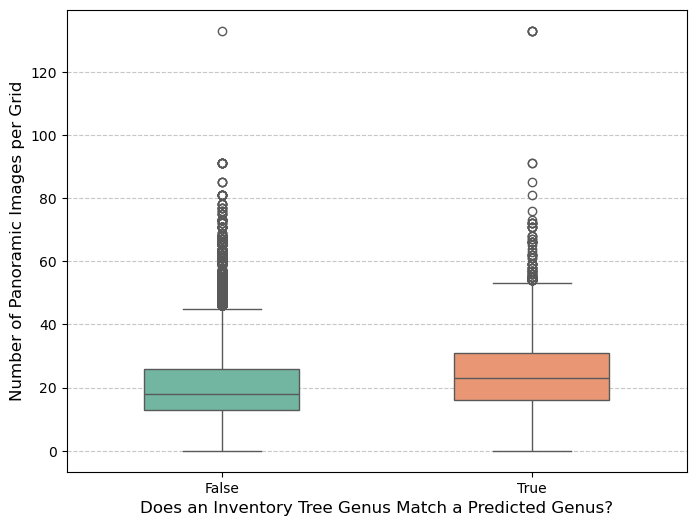

In [5]:
# Create boxplots for 'is_matched' versus 'grid_num_panos'
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_matched', y='grid_num_panos', data=df, palette="Set2", width=0.5, hue='is_matched')
plt.legend([], [], frameon=False)  # Hide legend if not needed

# Customize the plot
plt.xlabel("Does an Inventory Tree Genus Match a Predicted Genus?", fontsize=12)
plt.ylabel("Number of Panoramic Images per Grid", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#plt.savefig(f'C:/Users/talake2/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_num_panos_binary_greedy_match.png', dpi=300, bbox_inches='tight', format='png')
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_num_panos_binary_greedy_match.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

### Two-Sample t-test to compare means of two groups

In [6]:
# Average number of panoramic images for matching
mean_values = df.groupby('is_matched')['grid_num_panos'].mean()
print(mean_values)

# Count records for each category in 'is_matched'
counts = df['is_matched'].value_counts()
print(counts)

# Separate the data based on 'is_matched' values
matched_data = df[df['is_matched'] == True]['grid_num_panos']
unmatched_data = df[df['is_matched'] == False]['grid_num_panos']

is_matched
False    20.522668
True     24.692688
Name: grid_num_panos, dtype: float64
is_matched
False    43806
True      4445
Name: count, dtype: int64


In [7]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*scipy.stats.shapiro.*")

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(matched_data, unmatched_data)

# Display the results
print(f"T-statistic: {t_stat:.6f}")
print(f"P-value: {p_value:.6f}")

# Perform the Shapiro-Wilk test for normality - the data are not normally distributed
_, p_normal_matched = stats.shapiro(matched_data)
_, p_normal_unmatched = stats.shapiro(unmatched_data)

# Display the results
print(f"Shapiro-Wilk test for normality (Matched): p-value = {p_normal_matched:.3f}")
print(f"Shapiro-Wilk test for normality (Unmatched): p-value = {p_normal_unmatched:.3f}")

# If the data is not normally distributed, use the Mann-Whitney U test
u_stat, p_value_u = stats.mannwhitneyu(matched_data, unmatched_data)

# Display the result
print(f"U-statistic: {u_stat:.6f}")
print(f"P-value: {p_value_u:.6f}")

T-statistic: 23.822113
P-value: 0.000000
Shapiro-Wilk test for normality (Matched): p-value = 0.000
Shapiro-Wilk test for normality (Unmatched): p-value = 0.000
U-statistic: 119806816.000000
P-value: 0.000000


### Summary histograms: Number of Inventory Trees Per Grid, Number of Panos Per Grid, Proportion of Inventory Trees Matching Predictions, Min. Dist. to Nearest Neighbor,

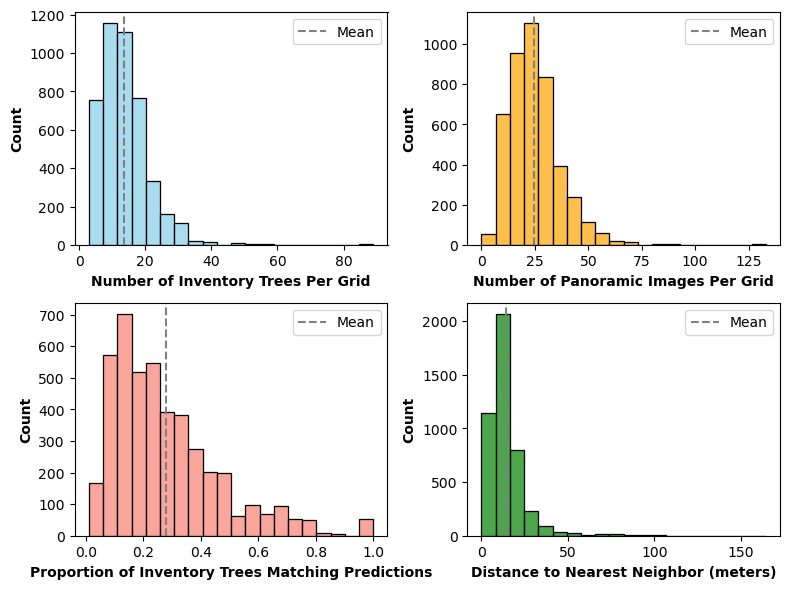

In [8]:
# Remove NA cases with no matches for plotting
df = df.replace([float('inf'), -float('inf')], pd.NA).dropna()

# Create a figure to contain the histograms
plt.figure(figsize=(8, 6))

# Plot histograms for each of the variables
# 1. Number of Inventory Trees
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='num_inv_trees', kde=False, color='skyblue', bins=20, alpha=0.7)
plt.axvline(df['num_inv_trees'].mean(), color="grey", linestyle='--', label='Mean')
plt.xlabel('Number of Inventory Trees Per Grid', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.legend()

# 2. Number of Panoramic Images
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='grid_num_panos', kde=False, color='orange', bins=20, alpha=0.7)
plt.axvline(df['grid_num_panos'].mean(), color="grey", linestyle='--', label='Mean')
plt.xlabel('Number of Panoramic Images Per Grid', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.legend()

# 3. Proportion of Inventory Trees Matching Predictions
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='proportion_matches', kde=False, color='salmon', bins=20, alpha=0.7)
plt.axvline(df['proportion_matches'].mean(), color="grey", linestyle='--', label='Mean')
plt.xlabel('Proportion of Inventory Trees Matching Predictions', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.legend()

# 4. Distance to Nearest Neighbor
plt.subplot(2, 2, 4)
sns.histplot(data=df, x='min_nn_distance', kde=False, color='green', bins=20, alpha=0.7)
plt.axvline(df['min_nn_distance'].mean(), color="grey", linestyle='--', label='Mean')
plt.xlabel('Distance to Nearest Neighbor (meters)', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure to the specified path
output_path = f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_histograms_trees_panos_matches_distances.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')

# Show the plots
plt.show()

### Boxplot: Number of Inventory Trees vs. Grid Density Level; Note: removed outlier to improve visualization

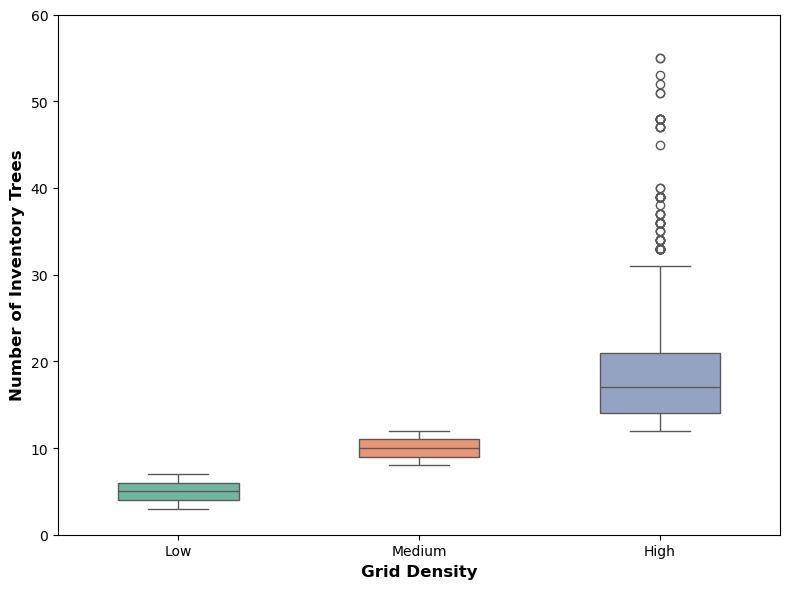

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='grid_density_level', y='num_inv_trees', hue='grid_density_level', palette='Set2', width=0.5, legend=False)

# Add labels
plt.xlabel('Grid Density', fontsize=12, fontweight='bold')
plt.ylabel('Number of Inventory Trees', fontsize=12, fontweight='bold')
plt.ylim(0, 60)  # Set y-axis limit

# Change x category labels
plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Medium', 'High'])

plt.tight_layout()
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_num_inv_trees_by_grid_density.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

### Boxplots - Relationship between Inventory Tree Density and Proportion of Matches by Genus


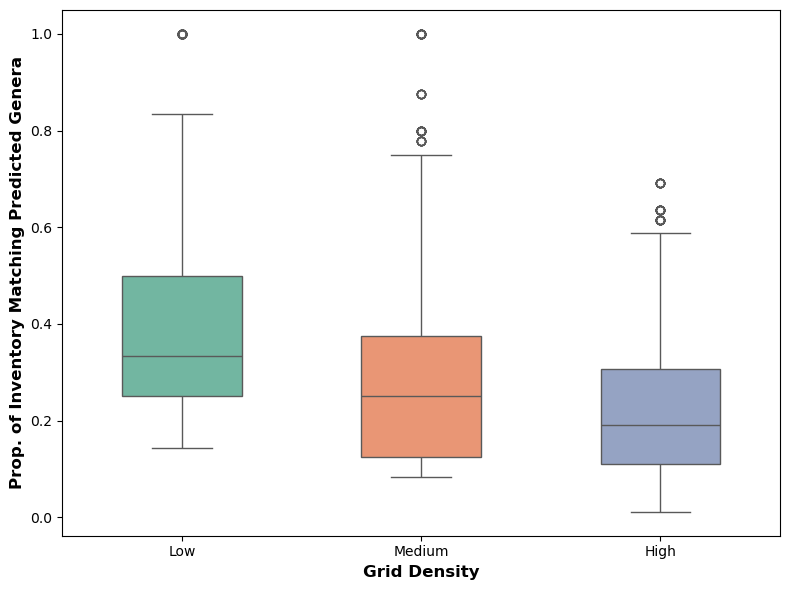

In [10]:
###
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='grid_density_level', y='proportion_matches', hue='grid_density_level', palette='Set2', width=0.5, legend=False)

# Add titles and labels
plt.xlabel('Grid Density', fontsize=12, fontweight='bold')
plt.ylabel('Prop. of Inventory Matching Predicted Genera', fontsize=12, fontweight='bold')

# Change x category labels
plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Medium', 'High'])

plt.tight_layout()
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_proportion_matches_by_grid_density.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

### Perform One-Way ANOVA based on Grid Density Level

In [11]:
# Separate the data based on 'grid_density_level'
low_density = df[df['grid_density_level'] == 'Low Density']['proportion_matches']
med_density = df[df['grid_density_level'] == 'Medium Density']['proportion_matches']
high_density = df[df['grid_density_level'] == 'High Density']['proportion_matches']

# Perform One-Way ANOVA
f_stat, p_value = stats.f_oneway(low_density, med_density, high_density)

# Display the results
print(f"F-statistic: {f_stat:.6f}")
print(f"P-value: {p_value:.6f}")

F-statistic: 340.234011
P-value: 0.000000


In [12]:
# Perform Shapiro-Wilk test for normality in each group
_, p_normal_low = stats.shapiro(low_density)
_, p_normal_med = stats.shapiro(med_density)
_, p_normal_high = stats.shapiro(high_density)

# Display normality results
print(f"Shapiro-Wilk test for normality (Low Density): p-value = {p_normal_low:.3f}")
print(f"Shapiro-Wilk test for normality (Medium Density): p-value = {p_normal_med:.3f}")
print(f"Shapiro-Wilk test for normality (High Density): p-value = {p_normal_high:.3f}")

# If data is not normal, use the Kruskal-Wallis test
h_stat, p_value_h = stats.kruskal(low_density, med_density, high_density)

# Display the result
print(f"H-statistic: {h_stat:.3f}")
print(f"P-value: {p_value_h:.3f}")

# Fit an ANOVA model
model = ols('proportion_matches ~ grid_density_level', data=df).fit()

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['proportion_matches'], groups=df['grid_density_level'], alpha=0.05)

# Display the results
print(tukey.summary())


Shapiro-Wilk test for normality (Low Density): p-value = 0.000
Shapiro-Wilk test for normality (Medium Density): p-value = 0.000
Shapiro-Wilk test for normality (High Density): p-value = 0.000
H-statistic: 518.976
P-value: 0.000
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1        group2     meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------
High Density    Low Density    0.192   0.0  0.1744  0.2096   True
High Density Medium Density   0.0758   0.0  0.0615  0.0901   True
 Low Density Medium Density  -0.1162   0.0 -0.1352 -0.0973   True
-----------------------------------------------------------------


### Boxplots - Relationship between Inventory Tree Density and Proportion of Matches by Genus

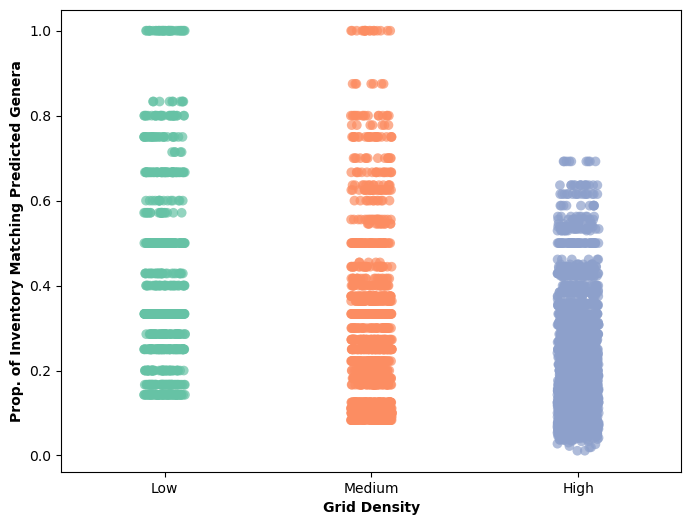

In [13]:
plt.figure(figsize=(8, 6))

# Assign the x variable to hue to avoid the warning
sns.stripplot(
    x='grid_density_level', 
    y='proportion_matches', 
    data=df, 
    palette="Set2", 
    jitter=True, 
    alpha=0.7, 
    size=7, 
    hue='grid_density_level'  # Assign hue to match x
)
plt.legend([], [], frameon=False)  # Hide legend if not needed

# Customize the plot
plt.xlabel("Grid Density", fontsize=10, fontweight='bold')
plt.ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=10, fontweight='bold')
plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Medium', 'High'])


# Save the plot
output_path = f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_stripplots_proportion_matches_by_grid_density.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')

plt.show()

### Boxplots - Relationship between Grid Density and Num. Panos per Grid

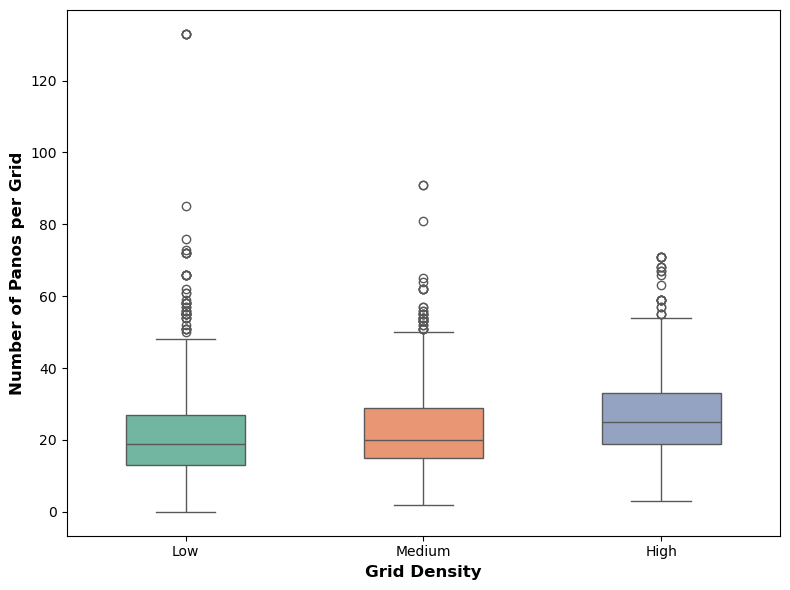

In [14]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='grid_density_level', y='grid_num_panos', hue='grid_density_level', palette='Set2', width=0.5, legend=False)

# Add titles and labels
plt.xlabel('Grid Density', fontsize=12, fontweight='bold')
plt.ylabel('Number of Panos per Grid', fontsize=12, fontweight='bold')

# Change x category labels
plt.xticks(ticks=[0, 1, 2], labels=['Low', 'Medium', 'High'])

plt.tight_layout()
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_num_panos_by_grid_density.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

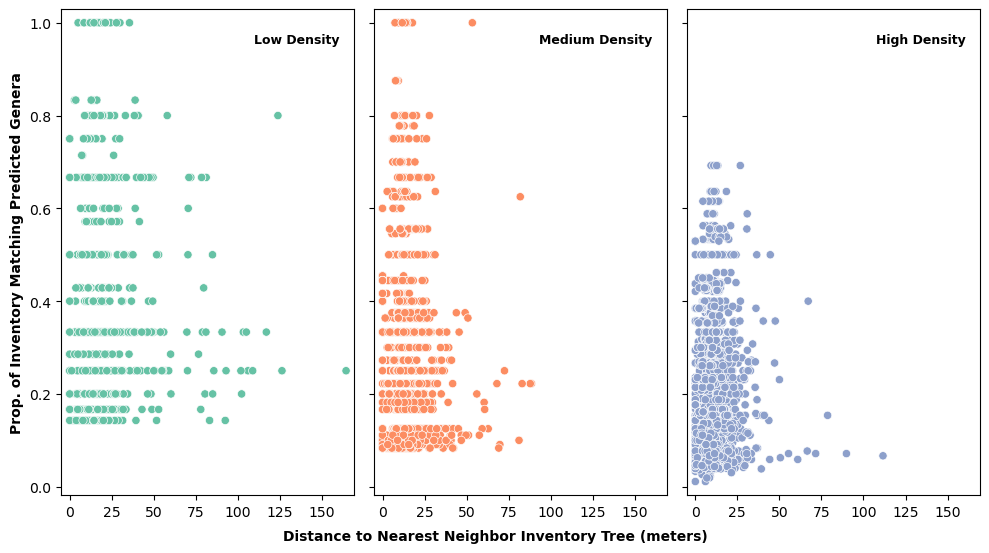

In [15]:
# Unique density levels in the dataset
density_levels = df['grid_density_level'].unique()

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharex=True, sharey=True)

# Define the color palette for consistency
palette = sns.color_palette("Set2", len(density_levels))

# Iterate through each density level and plot on separate subplots
for i, density in enumerate(density_levels):
  # Filter data for the current density level
  subset_df = df[df['grid_density_level'] == density]
  
  # Create the scatterplot
  sns.scatterplot(
    x='min_nn_distance', 
    y='proportion_matches', 
    data=subset_df, 
    hue='grid_density_level', 
    palette={density: palette[i]},  # Maintain the same color for each density
    ax=axes[i],
    legend=False  # Remove legend for individual plots
  )
  
  # Set the title for each subplot
  axes[i].set_ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=10, fontweight='bold')
  
  # Add the density label in the top right corner within each plot
  axes[i].text(
    0.95, 0.95, density, 
    horizontalalignment='right', 
    verticalalignment='top', 
    transform=axes[i].transAxes, 
    fontsize=9, 
    fontweight='bold',  # Make the density label bold
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
  )

# Set the same x and y axis limits for all subplots with buffer
x_min, x_max = df['min_nn_distance'].min(), df['min_nn_distance'].max()
y_min, y_max = df['proportion_matches'].min(), df['proportion_matches'].max()
x_buffer = (x_max - x_min) * 0.03
y_buffer = (y_max - y_min) * 0.03
for ax in axes:
  ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
  ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
  ax.set_xlabel("", fontsize=14, fontweight='bold')  # Remove x-axis label

# Add a single x-axis label for the entire figure
fig.text(0.5, 0.04, "Distance to Nearest Neighbor Inventory Tree (meters)", ha='center', fontsize=10, fontweight='bold')

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust the rect parameter to make space for the x-axis label

# Save the figure
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_scatterplot_proportion_matches_by_nearest_neighbor_density_comparison.png', dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()

### Boxplots - Relationship between Inventory Nearest Neighbor Distance and Proportion of Matches by Grid


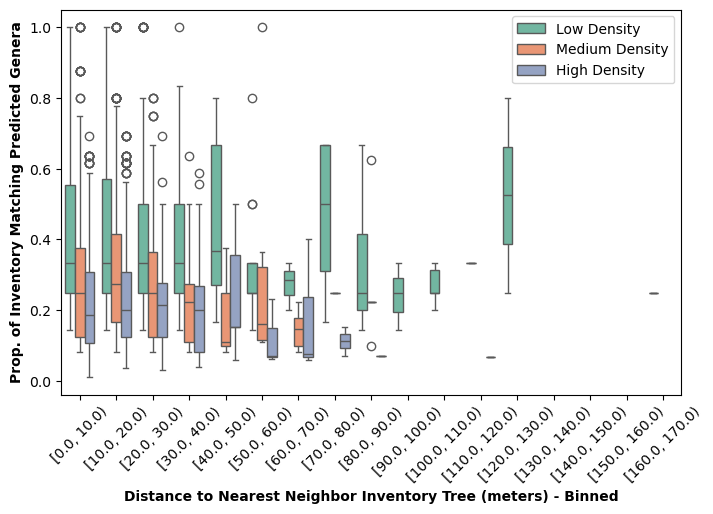

In [16]:
# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['min_nn_distance_bin'] = pd.cut(df['min_nn_distance'], bins=np.arange(0, df['min_nn_distance'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(8, 5))
sns.boxplot(x='min_nn_distance_bin', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Distance to Nearest Neighbor Inventory Tree (meters) - Binned", fontsize=10, fontweight='bold')
plt.ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=10, fontweight='bold')

plt.xticks(rotation=45)

# Remove the "grid_density_level" from the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(density_levels)], labels[:len(density_levels)], title='')

plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_proportion_matches_by_nearest_neighbor_density_categories.png', dpi=300, bbox_inches='tight', format='png')

plt.show()

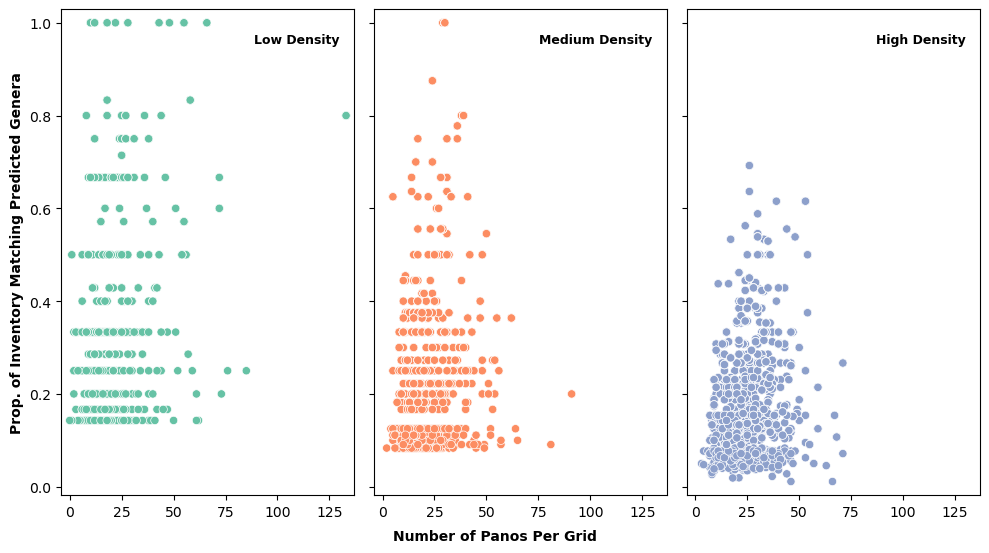

In [17]:
# Unique density levels in the dataset
density_levels = df['grid_density_level'].unique()

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharex=True, sharey=True)

# Define the color palette for consistency
palette = sns.color_palette("Set2", len(density_levels))

# Iterate through each density level and plot on separate subplots
for i, density in enumerate(density_levels):
  # Filter data for the current density level
  subset_df = df[df['grid_density_level'] == density]
  
  # Create the scatterplot
  sns.scatterplot(
    x='grid_num_panos', 
    y='proportion_matches', 
    data=subset_df, 
    hue='grid_density_level', 
    palette={density: palette[i]},  # Maintain the same color for each density
    ax=axes[i],
    legend=False  # Remove legend for individual plots
  )
  
  # Set the title for each subplot
  axes[i].set_ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=10, fontweight='bold')
  
  # Add the density label in the top right corner within each plot
  axes[i].text(
    0.95, 0.95, density, 
    horizontalalignment='right', 
    verticalalignment='top', 
    transform=axes[i].transAxes, 
    fontsize=9, 
    fontweight='bold',  # Make the density label bold
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
  )

# Set the same x and y axis limits for all subplots with buffer
x_min, x_max = df['grid_num_panos'].min(), df['grid_num_panos'].max()
y_min, y_max = df['proportion_matches'].min(), df['proportion_matches'].max()
x_buffer = (x_max - x_min) * 0.03
y_buffer = (y_max - y_min) * 0.03
for ax in axes:
  ax.set_xlim(x_min - x_buffer, x_max + x_buffer)
  ax.set_ylim(y_min - y_buffer, y_max + y_buffer)
  ax.set_xlabel("", fontsize=14, fontweight='bold')  # Remove x-axis label

# Add a single x-axis label for the entire figure
fig.text(0.5, 0.04, "Number of Panos Per Grid", ha='center', fontsize=10, fontweight='bold')

# Adjust layout for better appearance
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust the rect parameter to make space for the x-axis label

# Save the figure
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_scatterplot_proportion_matches_by_num_panos_density_comparison.png', dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()

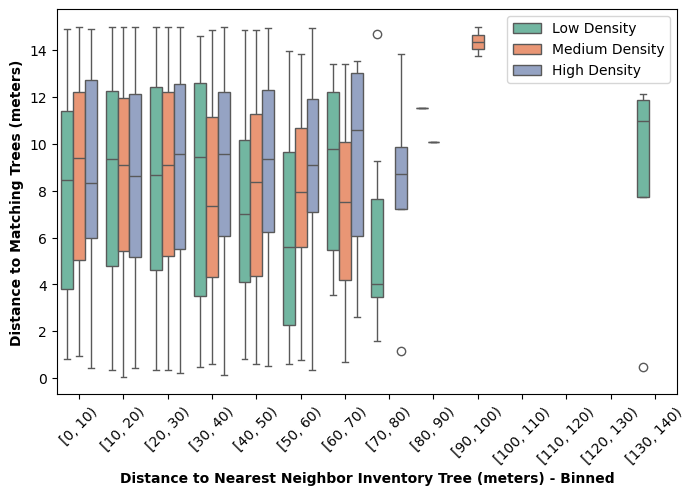

In [18]:
# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['grid_num_panos_bin'] = pd.cut(df['grid_num_panos'], bins=np.arange(0, df['grid_num_panos'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(8, 5))
sns.boxplot(x='grid_num_panos_bin', y='match_distance', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Distance to Nearest Neighbor Inventory Tree (meters) - Binned", fontsize=10, fontweight='bold')
plt.ylabel("Distance to Matching Trees (meters)", fontsize=10, fontweight='bold')

plt.xticks(rotation=45)
# Remove the "grid_density_level" from the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(density_levels)], labels[:len(density_levels)], title='')
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_boxplots_distance matching_trees_by_nearest_neighbor_density_categories.png', dpi=300, bbox_inches='tight', format='png')
plt.show()

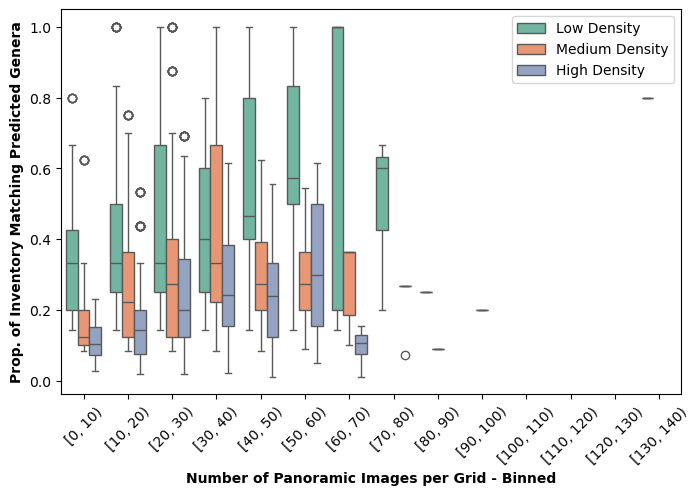

In [19]:
# Boxplots - Relationship between Num. Panos per Grid and Proportion of Matches by Genus

# Create a new column for binning the min_nn_distance by intervals of 10 meters
df['grid_num_panos_bin'] = pd.cut(df['grid_num_panos'], bins=np.arange(0, df['grid_num_panos'].max() + 10, 10), right=False)

# Create a boxplot for each 10-meter interval
plt.figure(figsize=(8, 5))
sns.boxplot(x='grid_num_panos_bin', y='proportion_matches', data=df, palette="Set2", hue='grid_density_level')

# Customize the plot
plt.xlabel("Number of Panoramic Images per Grid - Binned", fontsize=10, fontweight='bold')
plt.ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=10, fontweight='bold')
plt.xticks(rotation=45)
# Remove the "grid_density_level" from the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(density_levels)], labels[:len(density_levels)], title='')
plt.savefig(f'/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/{city}_prop_trees matching_by_number_of_panoramic_images_grid.png', dpi=300, bbox_inches='tight', format='png')


plt.show()

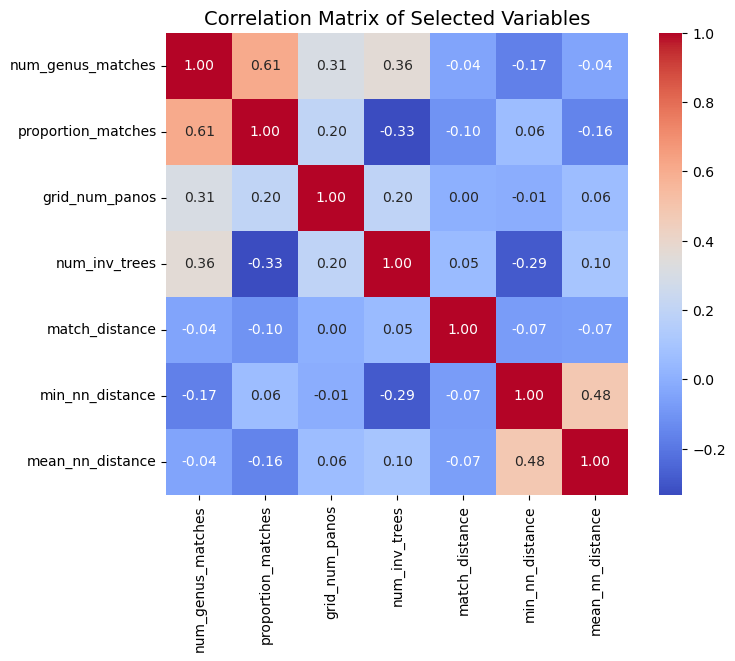

In [20]:
# Select only the specified numeric columns from the dataframe
selected_columns = ['num_genus_matches', 'proportion_matches', 'grid_num_panos', 'num_inv_trees', 'match_distance', 'min_nn_distance', 'mean_nn_distance']
numeric_df = df[selected_columns]

# Calculate the correlation matrix for the selected numeric variables
correlation_matrix = numeric_df.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True, square=True)

# Customize the heatmap
plt.title("Correlation Matrix of Selected Variables", fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10, rotation=0)

plt.show()


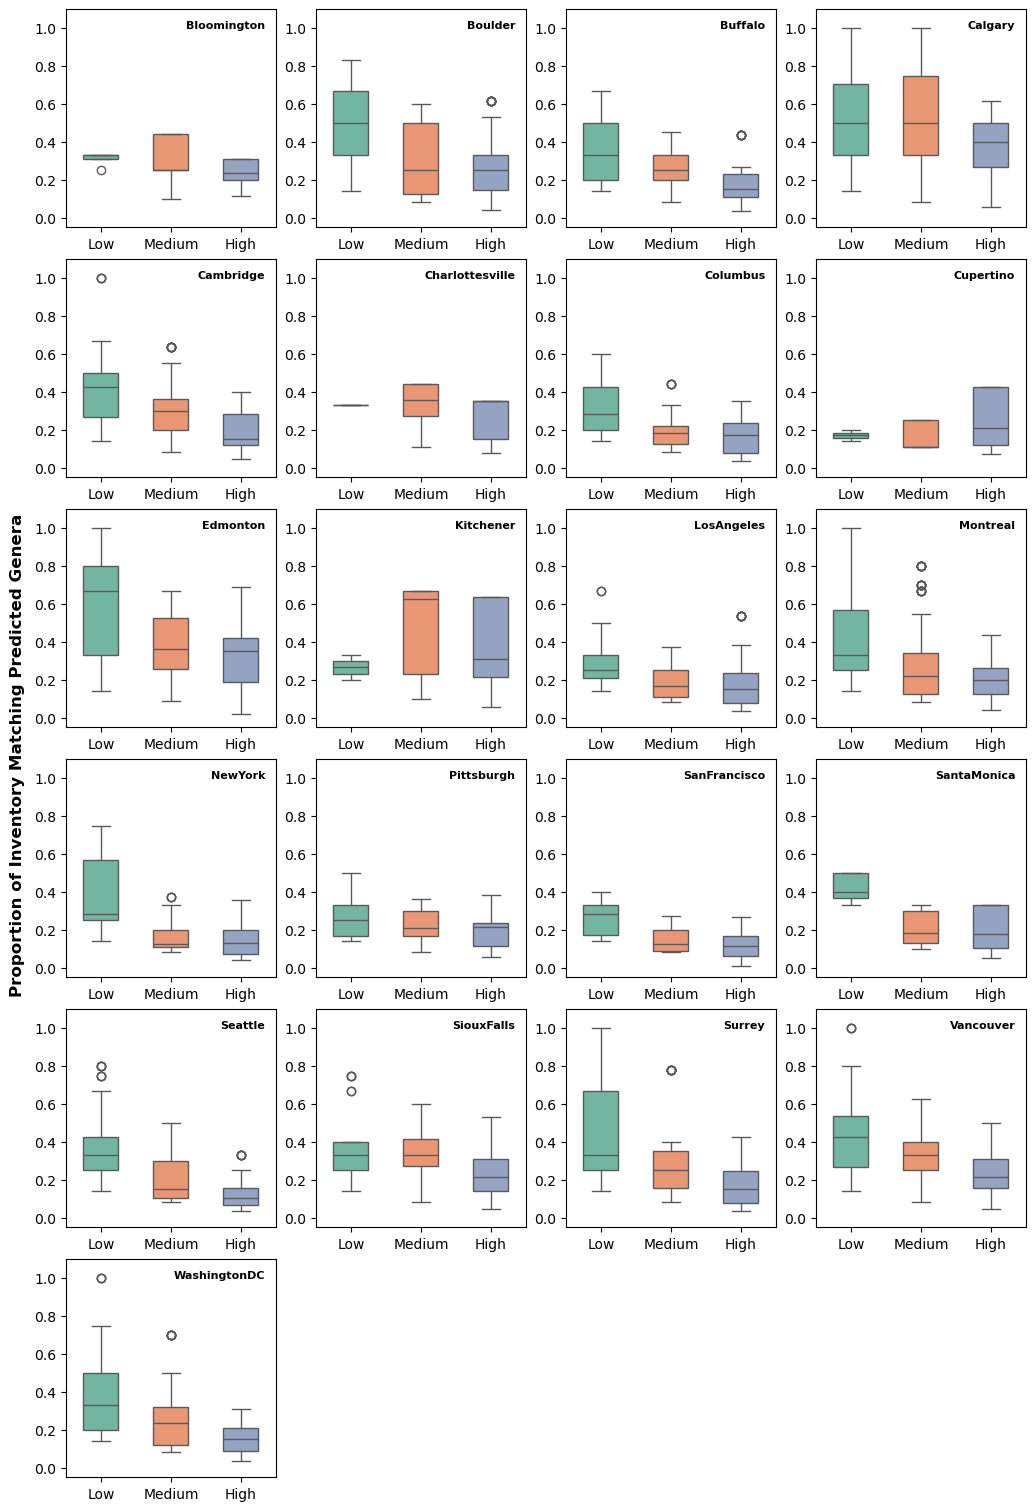

In [21]:
# Ensure unique cities are identified
unique_cities = np.sort(df['All_Cities'].unique())
num_cities = len(unique_cities)

# Set up the grid dimensions
rows = 6
cols = 4

# Calculate the figure size dynamically based on grid
fig, axes = plt.subplots(rows, cols, figsize=(10, 15), constrained_layout=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each city and create a boxplot
for i, city in enumerate(unique_cities):
  # Filter the DataFrame for the current city
  city_df = df[df['All_Cities'] == city]
  
  # Plot on the appropriate subplot
  sns.boxplot(
    x='grid_density_level', 
    y='proportion_matches', 
    hue='grid_density_level',
    data=city_df, 
    ax=axes[i], 
    palette="Set2", 
    width=0.5,
    legend=False
  )
  
  # Customize the subplot
  axes[i].set_xlabel("")
  axes[i].set_ylabel("")
  axes[i].set_xticks([0, 1, 2])  # Set the ticks first
  axes[i].set_xticklabels(["Low", "Medium", "High"])  # Update x labels
  axes[i].set_ylim(-0.05, 1.1)  # Set y-axis limits with a little buffer
  
  # Add the city name in the top right corner within each plot
  axes[i].text(
    0.95, 0.95, city, 
    horizontalalignment='right', 
    verticalalignment='top', 
    transform=axes[i].transAxes, 
    fontsize=8, 
    fontweight='bold',  # Make the city label bold
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
  )

# Turn off unused subplots
for j in range(len(unique_cities), len(axes)):
  axes[j].axis('off')

# Add a single y-axis label for all plots
fig.text(-0.02, 0.5, 'Proportion of Inventory Matching Predicted Genera', va='center', rotation='vertical', fontsize=12, fontweight='bold')

# Save the entire grid of plots
output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/per_city_boxplots_proportion_matches_by_grid_density.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()


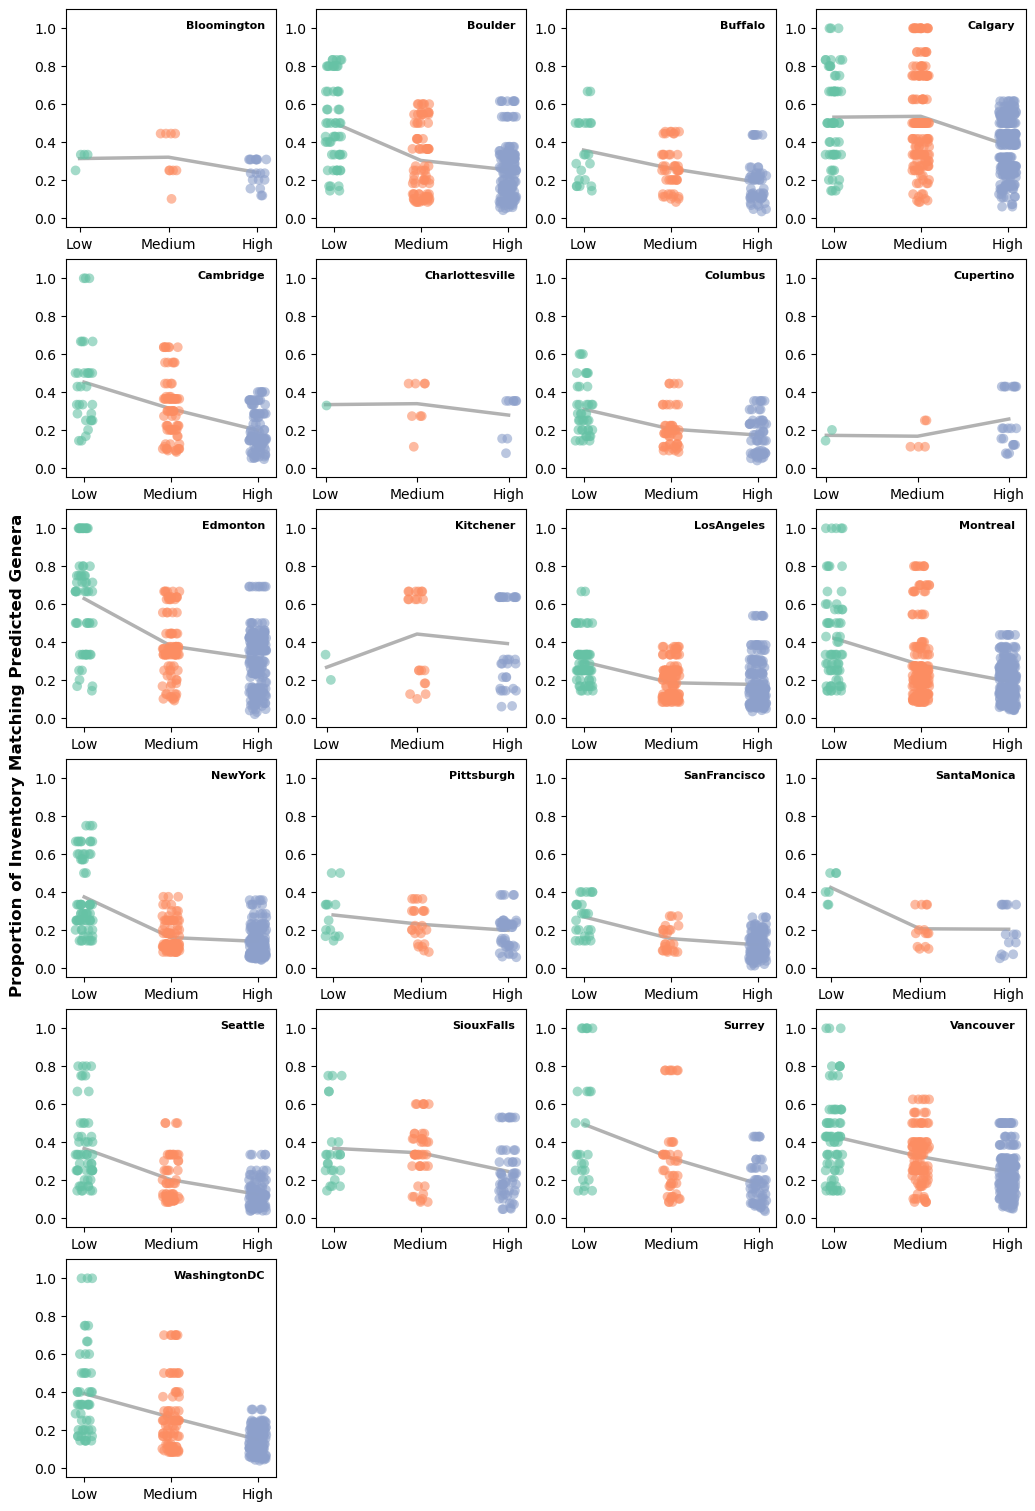

In [22]:
# Ensure unique cities are identified
unique_cities = np.sort(df['All_Cities'].unique())
num_cities = len(unique_cities)

# Set up the grid dimensions
rows = 6
cols = 4

# Calculate the figure size dynamically based on grid
fig, axes = plt.subplots(rows, cols, figsize=(10, 15), constrained_layout=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each city and create a jitter plot with a simple trend line
for i, city in enumerate(unique_cities):
    # Filter the DataFrame for the current city
    city_df = df[df['All_Cities'] == city]

    # Plot jitter points with partially transparent colors
    sns.stripplot(
        x='grid_density_level',
        y='proportion_matches',
        data=city_df,
        ax=axes[i],
        palette="Set2",
        jitter=True,
        alpha=0.6,  # Increase transparency
        size=7,
        hue='grid_density_level'
    )

    # Add a simple, thicker, and slightly transparent gray trend line
    sns.lineplot(
        x='grid_density_level',
        y='proportion_matches',
        data=city_df,
        ax=axes[i],
        color='gray',
        alpha=0.6,  # Slight transparency
        linewidth=2.5,  # Thicker line
        errorbar=None  # Suppress error bars to avoid warnings
    )
    
    # Customize the subplot
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([0, 1, 2])  # Set the ticks first
    axes[i].set_xticklabels(["Low", "Medium", "High"])  # Update x labels
    axes[i].set_ylim(-0.05, 1.1)  # Set y-axis limits with a little buffer
    
    # Add the city name in the top right corner within each plot
    axes[i].text(
        0.95, 0.95, city,
        horizontalalignment='right',
        verticalalignment='top',
        transform=axes[i].transAxes,
        fontsize=8,
        fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )
    
    # Hide the legend for individual subplots
    axes[i].legend([], [], frameon=False)

# Turn off unused subplots
for j in range(len(unique_cities), len(axes)):
    axes[j].axis('off')

# Add a single y-axis label for all plots
fig.text(-0.02, 0.5, 'Proportion of Inventory Matching Predicted Genera', va='center', rotation='vertical', fontsize=12, fontweight='bold')

# Save the entire grid of plots
output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/per_city_jitterplots_prop_matching_by_grid_density.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')

# Show the plot
plt.show()


## XY Plots Prop. of Matches by Number of Inventory Trees 

## Define functions of hypothesized (inverse) relationship between x and y; find best fit overall and per city

In [23]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)

# Define decay functions
def negative_exponential(x, a, b, c):
    return a * np.exp(-b * np.clip(x, 0, 1e6)) + c

def linear_decay(x, k, b):
    return -k * x + b

def polynomial_decay(x, a, n):
    return a * x**n

def hyperbolic_decay(x, a, b):
    return a / (1 + b * np.clip(x, 0, 1e6))

def weibull_decay(x, a, b, c):
    return a * np.exp(-((x / b)**c))

def reciprocal_decay(x, a, b):
    return a / (np.clip(x, 0, 1e6) + b)

def linear_function(x, m, c):
    return m * x + c

# Add jitter to the data
df['jittered_x'] = df['num_inv_trees'] + np.random.uniform(0, 0, size=len(df))

# Define all functions with labels
functions = [
    (negative_exponential, "Negative Exponential"),
    (linear_decay, "Linear Decay"),
    #(logarithmic_decay, "Logarithmic Decay"),
    (polynomial_decay, "Polynomial Decay"),
    (hyperbolic_decay, "Hyperbolic Decay"),
    #(logistic_function, "Logistic Function"),
    #(gompertz_curve, "Gompertz Curve"),
    (weibull_decay, "Weibull Decay"),
    (reciprocal_decay, "Reciprocal Decay"),
    (linear_function, "Linear Function"),
]

# Overall trend line
overall_rmse_results = []
x_fit_overall = np.linspace(df['num_inv_trees'].min(), df['num_inv_trees'].max(), 200)

for func, label in functions:
    try:
        popt, _ = curve_fit(
            func,
            df['num_inv_trees'],
            df['proportion_matches'],
            maxfev=10000
        )
        y_pred = func(df['num_inv_trees'], *popt)
        rmse = np.sqrt(mean_squared_error(df['proportion_matches'], y_pred))
        overall_rmse_results.append((label, rmse, popt))
    except Exception:
        pass

# Sort and select the best overall fit
overall_rmse_results.sort(key=lambda x: x[1])
best_overall_fit = overall_rmse_results[0]
logger.info(f"Best Overall Fit: {best_overall_fit[0]} with RMSE = {best_overall_fit[1]:.4f}")

# City-specific trend lines
grouped = df.groupby('All_Cities')
city_results = {}

for city, group in grouped:
    city_rmse_results = []
    for func, label in functions:
        try:
            popt, _ = curve_fit(
                func,
                group['num_inv_trees'],
                group['proportion_matches'],
                maxfev=10000
            )
            y_pred = func(group['num_inv_trees'], *popt)
            rmse = np.sqrt(mean_squared_error(group['proportion_matches'], y_pred))
            city_rmse_results.append((label, rmse, popt))
        except Exception:
            pass
    
    # Sort and select the best fit for the city
    city_rmse_results.sort(key=lambda x: x[1])
    best_city_fit = city_rmse_results[0]
    logger.info(f"Best Fit for {city}: {best_city_fit[0]} with RMSE = {best_city_fit[1]:.4f}")
    city_results[city] = city_rmse_results

# Prepare results for export
results_list = []
best_results_list = []

# Add overall results
for result in overall_rmse_results:
    results_list.append({
        'Scope': 'Overall',
        'City': 'All',
        'Function': result[0],
        'RMSE': result[1],
        'Parameters': result[2]
    })

# Add city-specific results
for city, results in city_results.items():
    for result in results:
        results_list.append({
            'Scope': 'City',
            'City': city,
            'Function': result[0],
            'RMSE': result[1],
            'Parameters': result[2]
        })
    # Add best fit for each city
    best_fit = results[0]
    best_results_list.append({
        'Scope': 'City',
        'City': city,
        'Function': best_fit[0],
        'RMSE': best_fit[1],
        'Parameters': best_fit[2]
    })

# Add best overall result
best_results_list.append({
    'Scope': 'Overall',
    'City': 'All',
    'Function': best_overall_fit[0],
    'RMSE': best_overall_fit[1],
    'Parameters': best_overall_fit[2]
})

# Export all results to CSV
results_df = pd.DataFrame(results_list)
results_df.to_csv('/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/all_cities_all_rmse_prop_matches_num_inv_trees.csv', index=False)

# Export best results to CSV
best_results_df = pd.DataFrame(best_results_list)
best_results_df.to_csv('/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/all_cities_best_rmse_prop_matches_num_inv_trees.csv', index=False)

logger.info("All results saved to 'all_fitting_results.csv'.")
logger.info("Best results saved to 'best_fitting_results.csv'.")

Best Overall Fit: Polynomial Decay with RMSE = 0.1764
Best Fit for Bloomington: Weibull Decay with RMSE = 0.0784
Best Fit for Boulder: Reciprocal Decay with RMSE = 0.1676
Best Fit for Buffalo: Polynomial Decay with RMSE = 0.1173
Best Fit for Calgary: Weibull Decay with RMSE = 0.1992
Best Fit for Cambridge: Polynomial Decay with RMSE = 0.1422
Best Fit for Charlottesville: Polynomial Decay with RMSE = 0.1127
Best Fit for Columbus: Weibull Decay with RMSE = 0.1106
Best Fit for Cupertino: Weibull Decay with RMSE = 0.1280
Best Fit for Edmonton: Negative Exponential with RMSE = 0.1739
Best Fit for Kitchener: Hyperbolic Decay with RMSE = 0.2004
Best Fit for LosAngeles: Polynomial Decay with RMSE = 0.1078
Best Fit for Montreal: Negative Exponential with RMSE = 0.1683
Best Fit for NewYork: Negative Exponential with RMSE = 0.1059
Best Fit for Pittsburgh: Polynomial Decay with RMSE = 0.0917
Best Fit for SanFrancisco: Weibull Decay with RMSE = 0.0638
Best Fit for SantaMonica: Polynomial Decay with

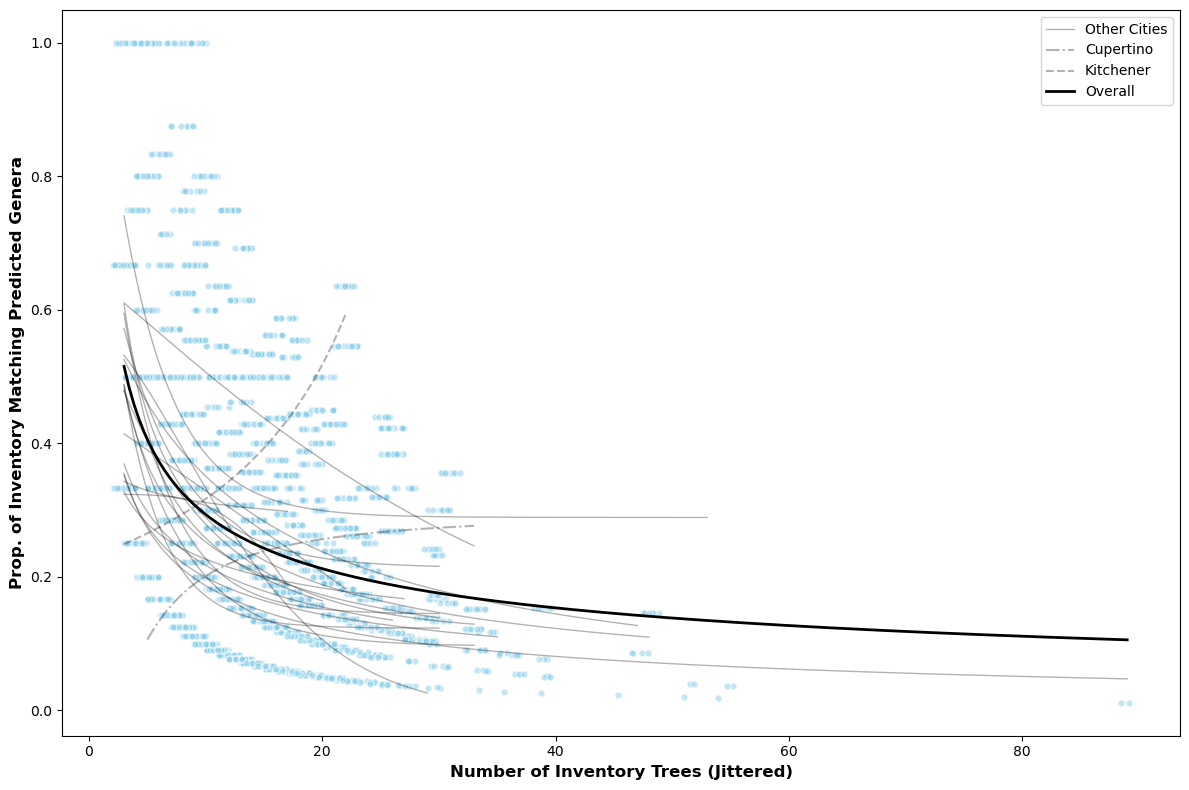

In [24]:
plt.figure(figsize=(12, 8))

# Add jitter to the data
df['jittered_x'] = df['num_inv_trees'] + np.random.uniform(-1, 1, size=len(df))


# Plot best fit for each city with specific styles for Kitchener and Cupertino (formerly Sioux Falls)
for city, group in grouped:
    # Retrieve the best fit for the city
    best_fit_city = next(
        (result for result in best_results_list if result['City'] == city and result['Scope'] == 'City'), 
        None
    )
    if best_fit_city:
        best_func = [func for func, label in functions if label == best_fit_city['Function']][0]
        x_fit_city = np.linspace(group['num_inv_trees'].min(), group['num_inv_trees'].max(), 200)
        y_fit_city = best_func(x_fit_city, *best_fit_city['Parameters'])
        
        # Style based on city
        if city == "Kitchener":
            plt.plot(
                x_fit_city, 
                y_fit_city, 
                linestyle='--', 
                color='black',
                alpha=0.3, 
                linewidth=1.5, 
                label="Kitchener" if city == "Kitchener" else None,
                zorder=2
            )
        elif city == "Cupertino":
            plt.plot(
                x_fit_city, 
                y_fit_city, 
                linestyle='-.', 
                color='black',
                alpha=0.3, 
                linewidth=1.5, 
                label="Cupertino" if city == "Cupertino" else None,
                zorder=2
            )
        else:
            plt.plot(
                x_fit_city, 
                y_fit_city, 
                linestyle='-', 
                color='black', 
                alpha=0.3, 
                linewidth=1, 
                label=None if city != list(grouped.groups.keys())[0] else "Other Cities",
                zorder=2
            )

# Plot the overall best fit
best_func_overall = [func for func, label in functions if label == best_overall_fit[0]][0]
y_fit_overall = best_func_overall(x_fit_overall, *best_overall_fit[2])

plt.plot(
    x_fit_overall, 
    y_fit_overall, 
    color='black', 
    linewidth=2, 
    label="Overall",
    zorder=3
)

# Scatter plot for raw data with white outline around points
plt.scatter(
    df['jittered_x'], 
    df['proportion_matches'], 
    color='skyblue', 
    edgecolors='white', 
    alpha=0.5, 
    s=25, 
    zorder=1  # Scatter points are behind the trend lines
)

# Customize the plot
plt.xlabel("Number of Inventory Trees (Jittered)", fontsize=12, fontweight='bold')
plt.ylabel("Prop. of Inventory Matching Predicted Genera", fontsize=12, fontweight='bold')

# Add legend without "Fit Lines" title
plt.legend(loc="upper right", fontsize=10, frameon=True, title=None)

plt.tight_layout()

# Save and show the plot
output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/all_cities_per_city_prop_matches_num_inv_trees_w_trendlines.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', format='png')
plt.show()

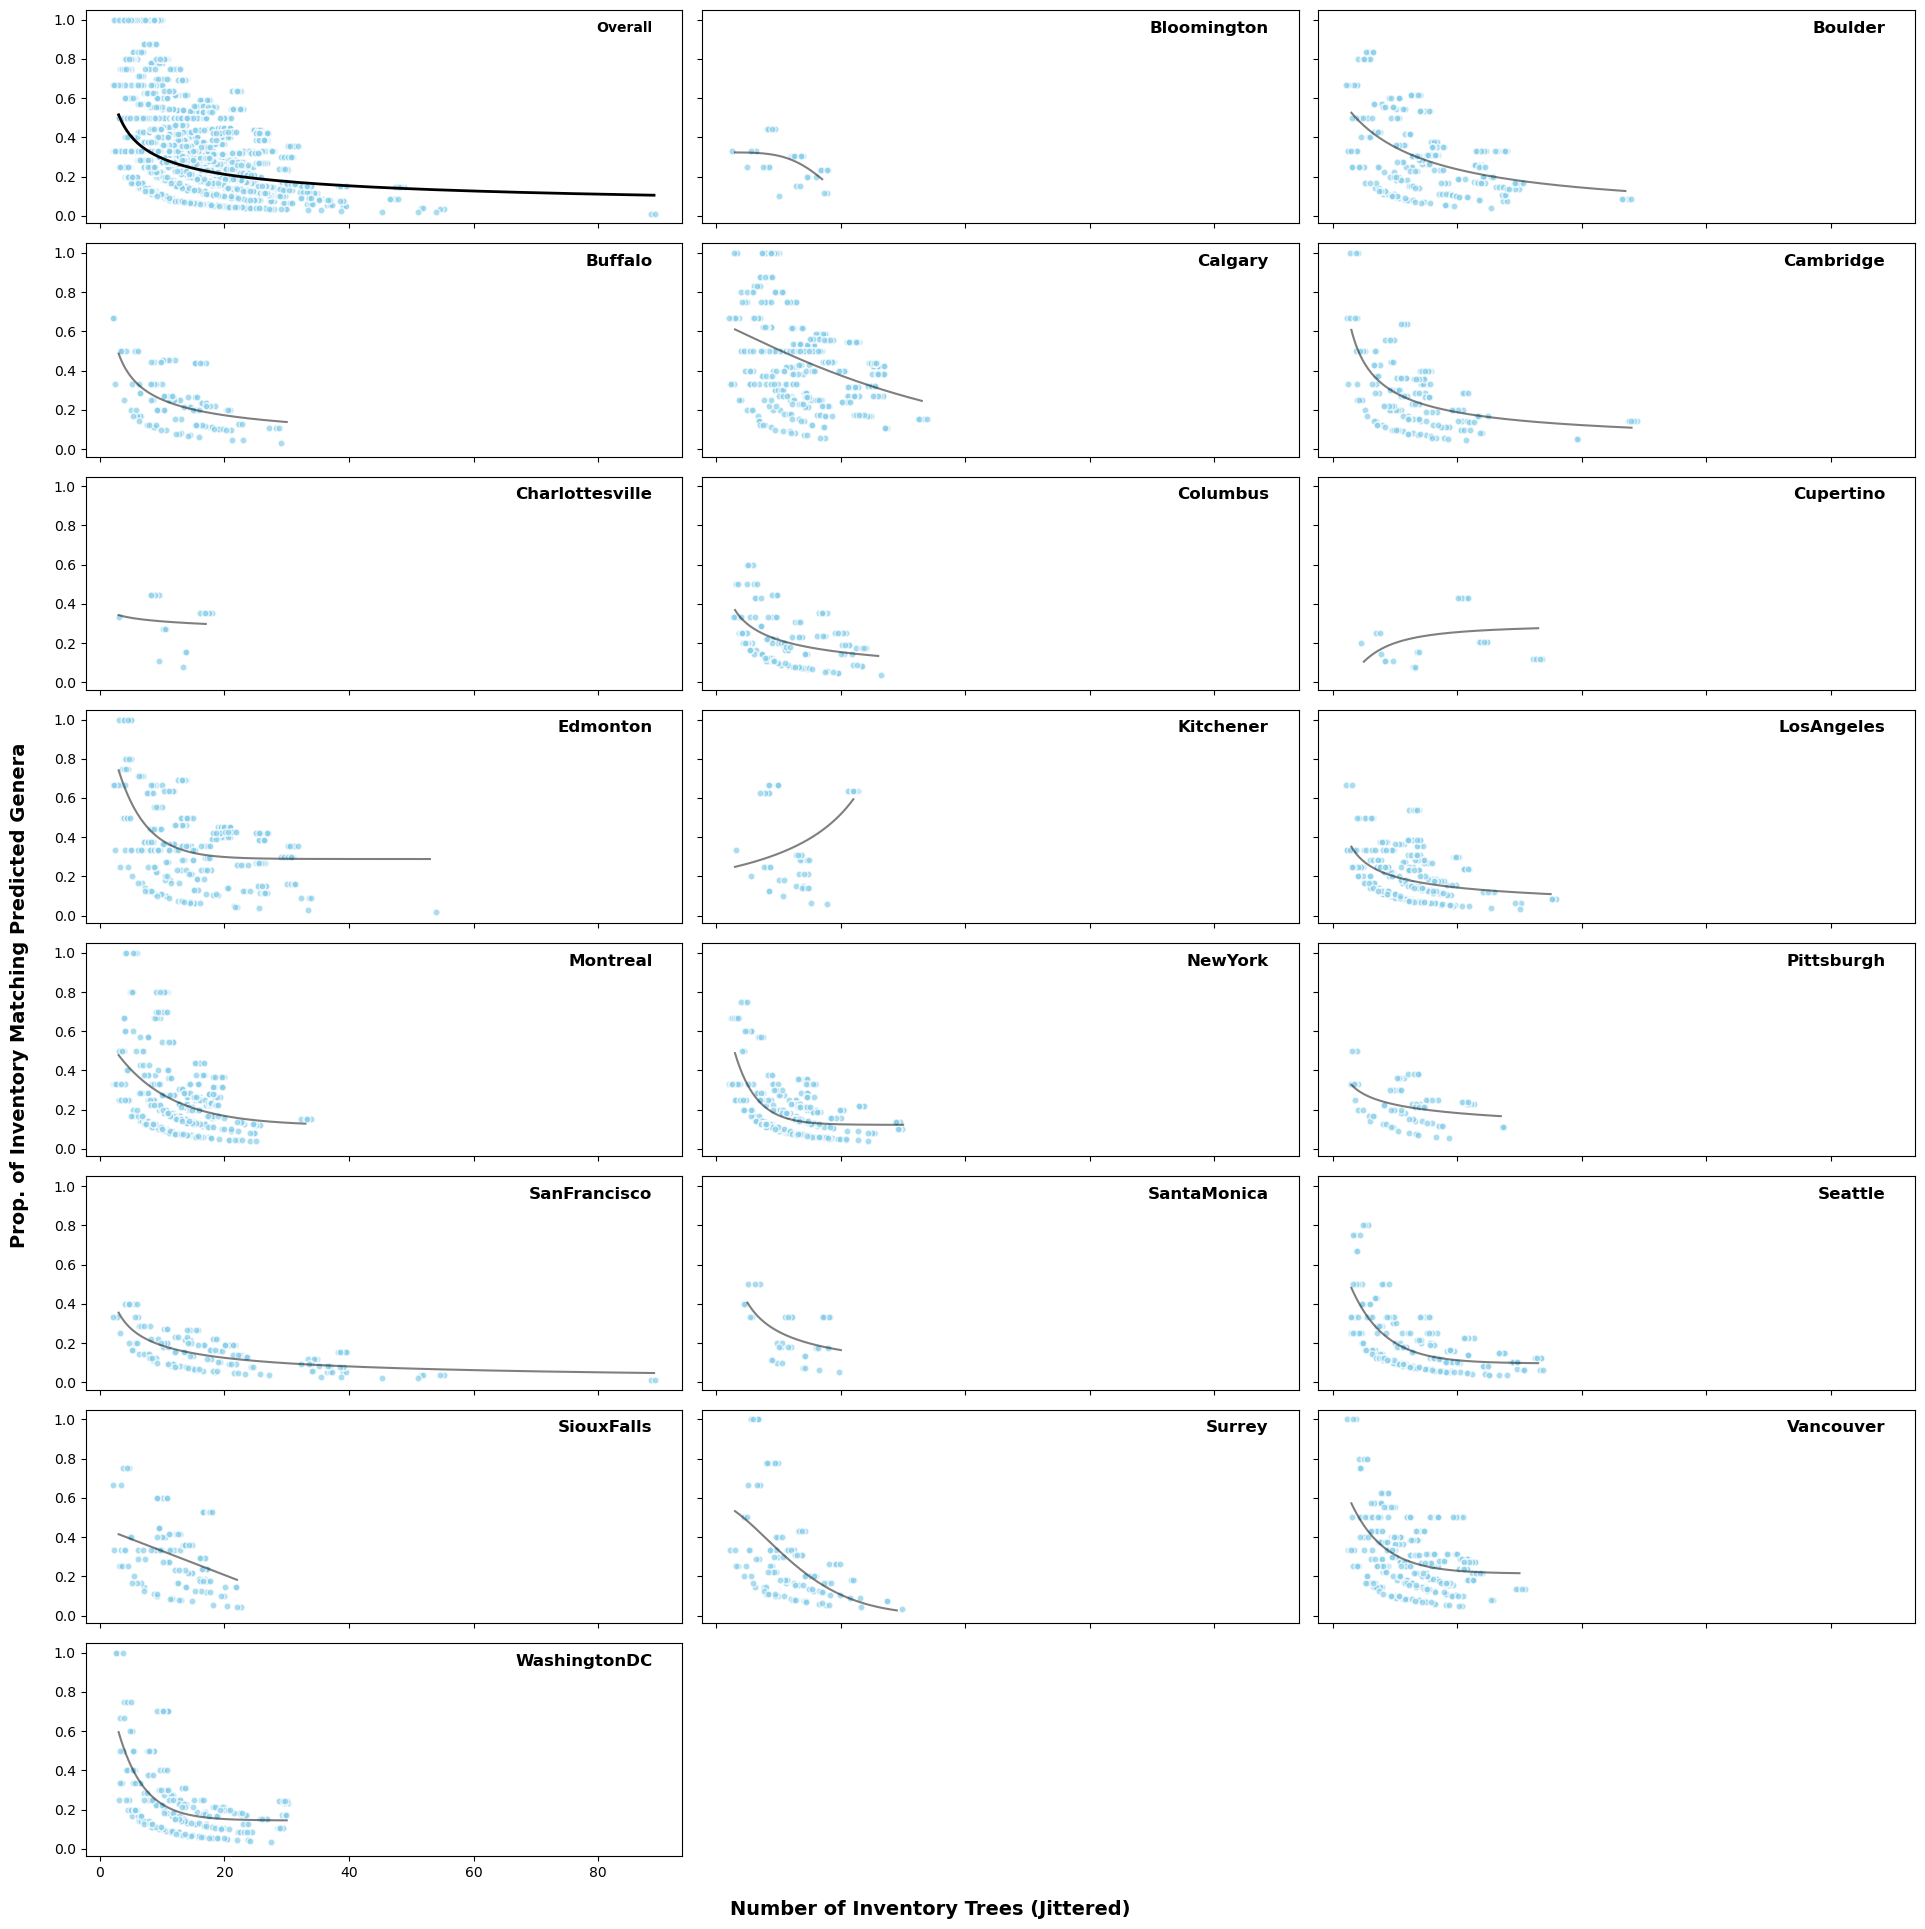

In [25]:
# Determine the number of required subplots based on data
total_plots = len(grouped) + 1  # Adding 1 for the overall plot
rows = (total_plots // 3) + (1 if total_plots % 3 != 0 else 0)

# Create figure and subplots
fig, axes = plt.subplots(rows, 3, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Plot overall in the first subplot
ax = axes[0]
ax.plot(x_fit_overall, y_fit_overall, color='black', linewidth=2, label="Overall", zorder=3)
ax.scatter(
    df['jittered_x'], 
    df['proportion_matches'], 
    color='skyblue', 
    edgecolors='white', 
    alpha=0.7, 
    s=25, 
    zorder=1
)
ax.text(0.95, 0.95, "Overall", fontsize=10, fontweight="bold", transform=ax.transAxes, ha="right", va="top")

# Plot each city in alphabetical order
for i, (city, group) in enumerate(sorted(grouped, key=lambda x: x[0]), start=1):
    ax = axes[i]

    # Retrieve the best fit for the city
    best_fit_city = next(
        (result for result in best_results_list if result['City'] == city and result['Scope'] == 'City'), 
        None
    )
    if best_fit_city:
        best_func = [func for func, label in functions if label == best_fit_city['Function']][0]
        x_fit_city = np.linspace(group['num_inv_trees'].min(), group['num_inv_trees'].max(), 200)
        y_fit_city = best_func(x_fit_city, *best_fit_city['Parameters'])

        # Style based on city
        ax.plot(
            x_fit_city, 
            y_fit_city, 
            linestyle='-', 
            color='black', 
            alpha=0.5, 
            linewidth=1.5,
            zorder=2
        )

    # Scatter plot for the city
    ax.scatter(
        group['jittered_x'], 
        group['proportion_matches'], 
        color='skyblue', 
        edgecolors='white', 
        alpha=0.7, 
        s=25, 
        zorder=1
    )
    ax.text(0.95, 0.95, city, fontsize=12, fontweight="bold", transform=ax.transAxes, ha="right", va="top")

# Hide any unused subplots
for j in range(total_plots, len(axes)):
    fig.delaxes(axes[j])

# Add shared x and y axis labels
fig.text(0.5, 0.04, 'Number of Inventory Trees (Jittered)', ha='center', fontsize=14, fontweight='bold')
fig.text(0.04, 0.5, 'Prop. of Inventory Matching Predicted Genera', va='center', rotation='vertical', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

# Save and show
output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/all_cities_per_city_prop_matches_num_inv_trees_w_trendlines_facet.png'
plt.savefig(output_path, dpi=300, bbox_inches="tight", format="png")
plt.show()

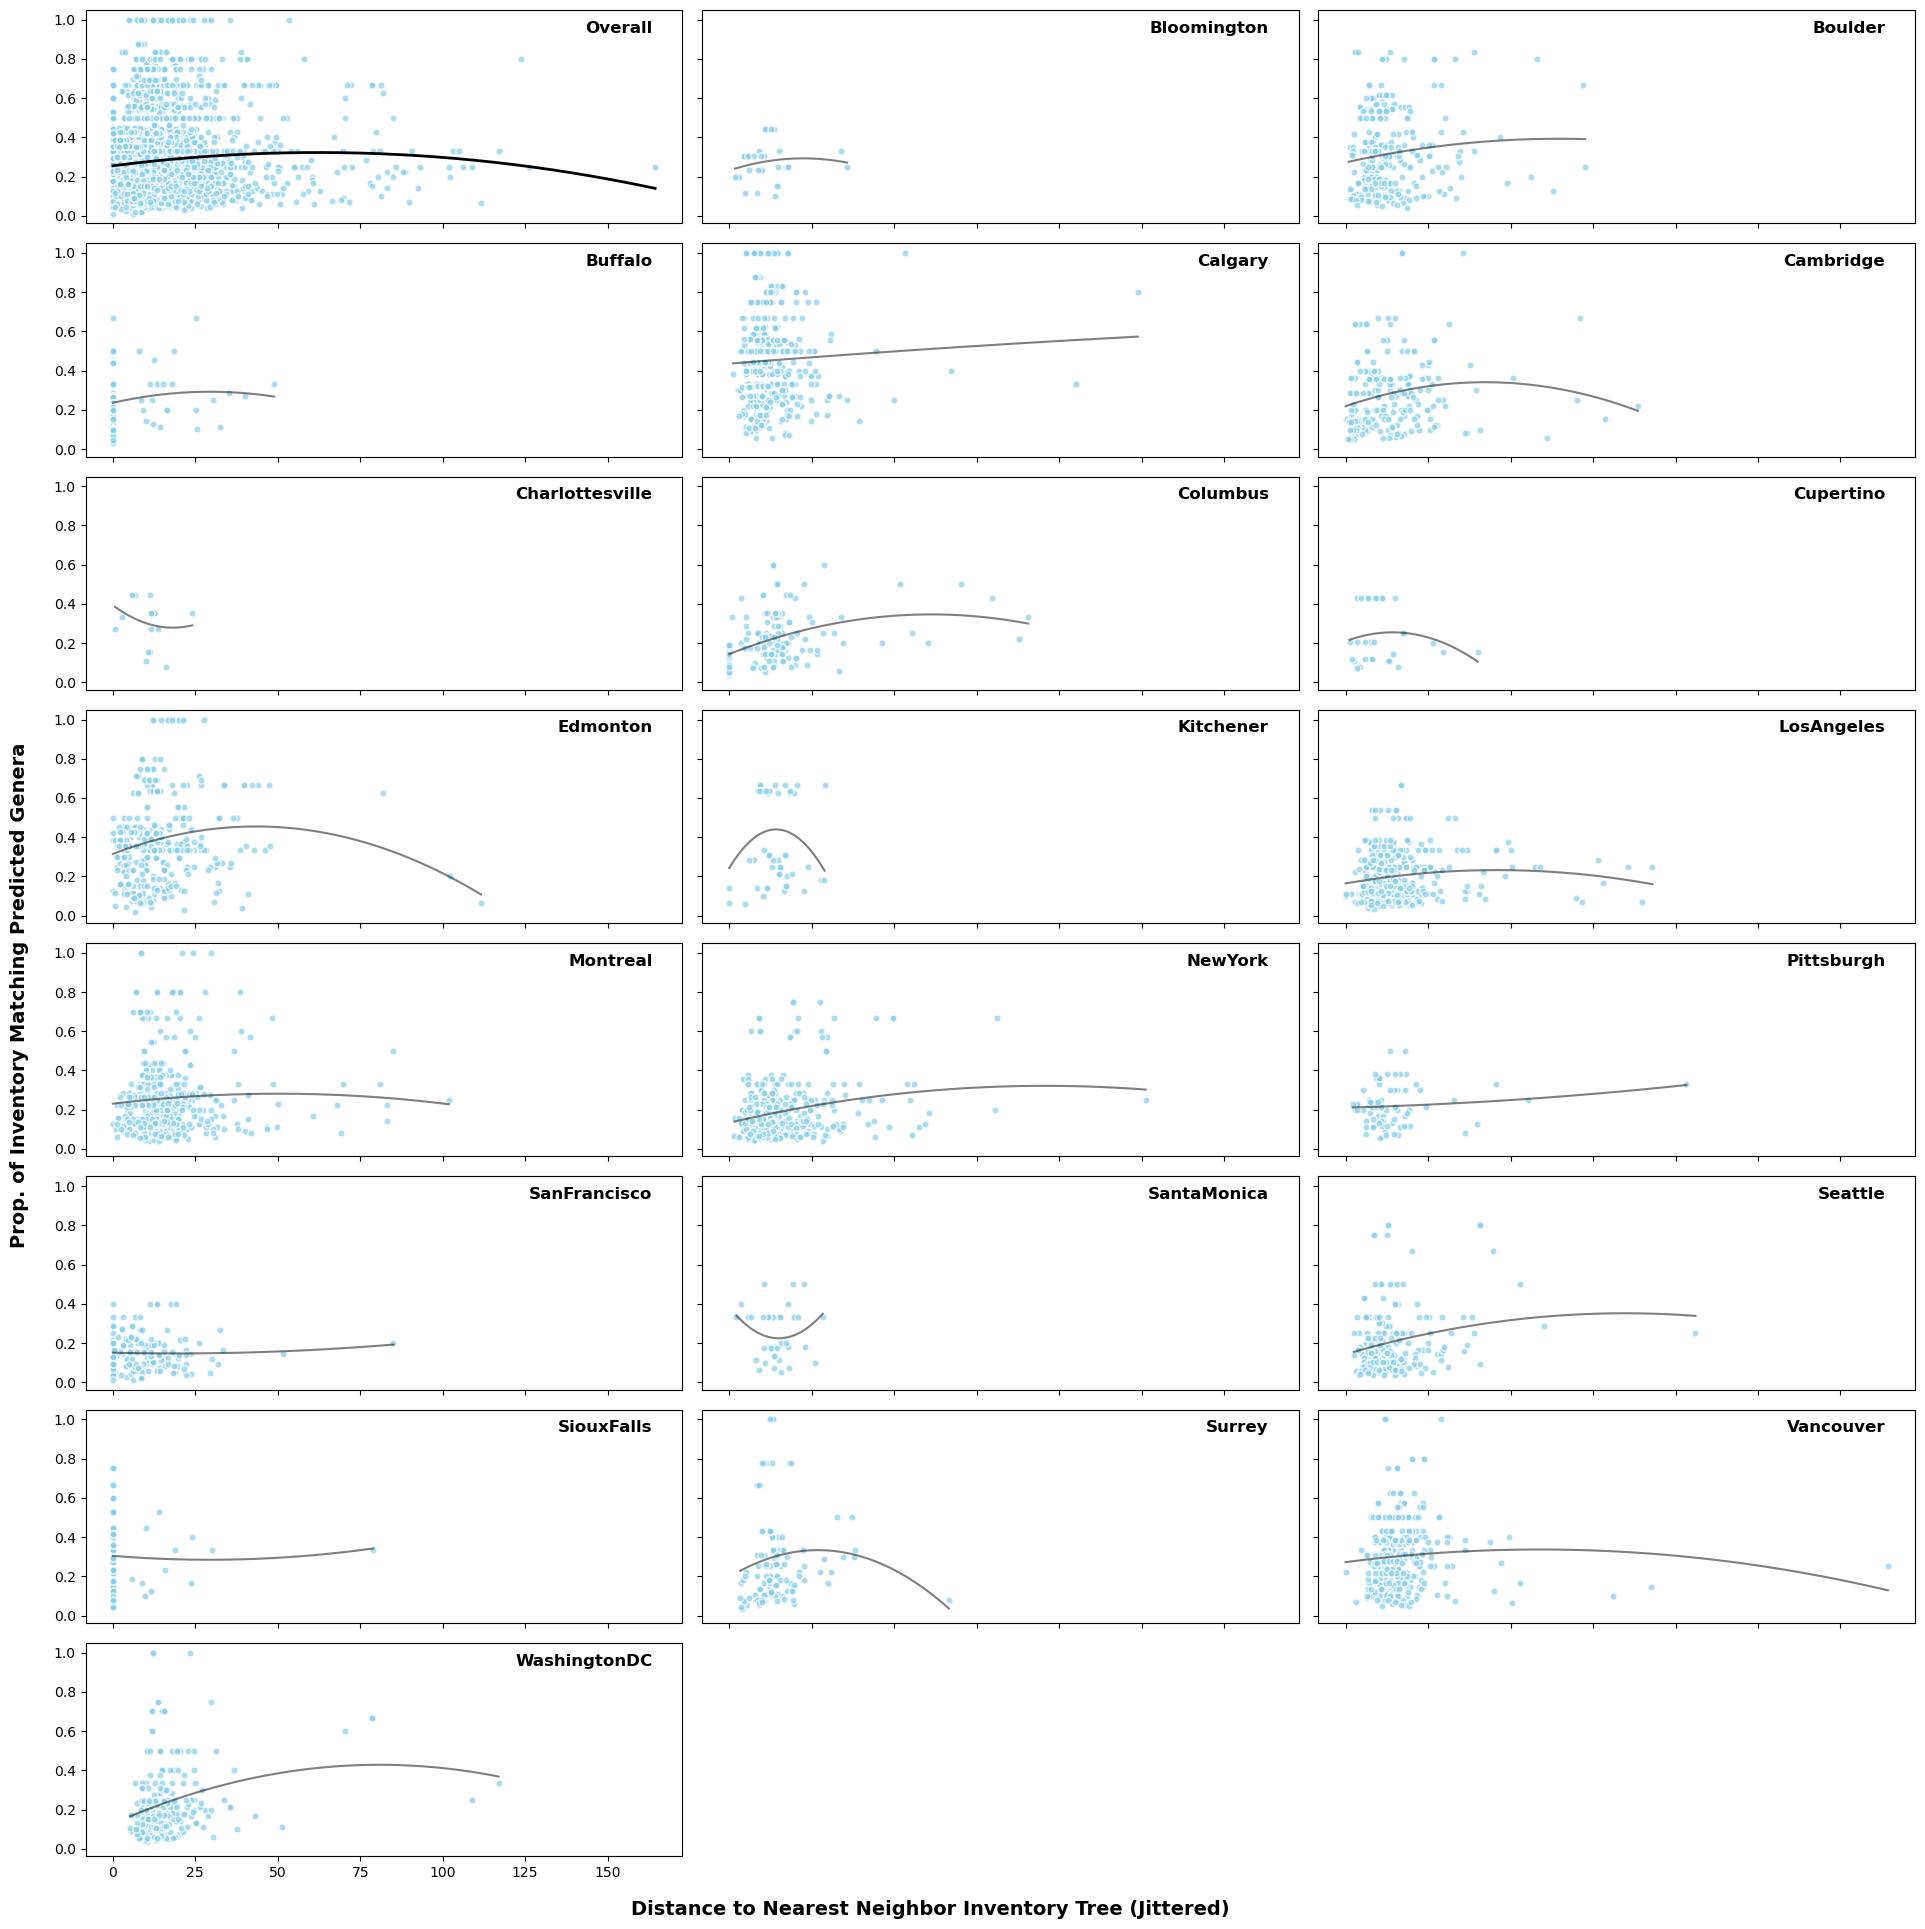

In [26]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

# Define linear and polynomial functions
def linear_func(x, m, c):
  return m * x + c

def poly_func(x, a, b, c):
  return a * x**2 + b * x + c

# Fit models and calculate RMSE
def fit_and_evaluate(x, y):
  # Fit linear model
  popt_linear, _ = curve_fit(linear_func, x, y)
  y_pred_linear = linear_func(x, *popt_linear)
  rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
  
  # Fit polynomial model
  popt_poly, _ = curve_fit(poly_func, x, y)
  y_pred_poly = poly_func(x, *popt_poly)
  rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
  
  return (popt_linear, rmse_linear), (popt_poly, rmse_poly)

# Fit and evaluate models for overall data
overall_linear, overall_poly = fit_and_evaluate(df['min_nn_distance'], df['proportion_matches'])

# Determine the best overall fit
best_overall_fit = overall_linear if overall_linear[1] < overall_poly[1] else overall_poly
best_overall_func = linear_func if overall_linear[1] < overall_poly[1] else poly_func

# Fit and evaluate models for each city
city_fits = {}
for city, group in df.groupby('All_Cities'):
  linear_fit, poly_fit = fit_and_evaluate(group['min_nn_distance'], group['proportion_matches'])
  best_fit = linear_fit if linear_fit[1] < poly_fit[1] else poly_fit
  city_fits[city] = best_fit

# Plot overall and per city subplots with best fit trendline
total_plots = len(city_fits) + 1
rows = (total_plots // 3) + (1 if total_plots % 3 != 0 else 0)

fig, axes = plt.subplots(rows, 3, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Plot overall in the first subplot
x_fit_overall = np.linspace(df['min_nn_distance'].min(), df['min_nn_distance'].max(), 200)
y_fit_overall = best_overall_func(x_fit_overall, *best_overall_fit[0])

axes[0].plot(x_fit_overall, y_fit_overall, color='black', linewidth=2, label="Overall")
axes[0].scatter(df['min_nn_distance'], df['proportion_matches'], color='skyblue', edgecolors='white', alpha=0.7, s=25)
axes[0].text(0.95, 0.95, "Overall", fontsize=12, fontweight="bold", transform=axes[0].transAxes, ha="right", va="top")

# Plot each city
for i, (city, group) in enumerate(df.groupby('All_Cities'), start=1):
  x_fit_city = np.linspace(group['min_nn_distance'].min(), group['min_nn_distance'].max(), 200)
  best_fit_func = linear_func if city_fits[city][1] < city_fits[city][1] else poly_func
  y_fit_city = best_fit_func(x_fit_city, *city_fits[city][0])
  axes[i].scatter(group['min_nn_distance'], group['proportion_matches'], color='skyblue', edgecolors='white', alpha=0.7, s=25)
  axes[i].plot(x_fit_city, y_fit_city, color='black', linewidth=1.5, alpha=0.5)
  axes[i].text(0.95, 0.95, city, fontsize=12, fontweight="bold", transform=axes[i].transAxes, ha="right", va="top")

# Hide unused subplots
for j in range(total_plots, len(axes)):
  fig.delaxes(axes[j])

# Add shared x and y axis labels
fig.text(0.5, 0.04, 'Distance to Nearest Neighbor Inventory Tree (Jittered)', ha='center', fontsize=14, fontweight='bold')
fig.text(0.04, 0.5, 'Prop. of Inventory Matching Predicted Genera', va='center', rotation='vertical', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

# Save and show the plot
#output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/all_cities_facet_plot_prop_matches_min_nn_distance.png'
#plt.savefig(output_path, dpi=300, bbox_inches="tight", format="png")
plt.show()

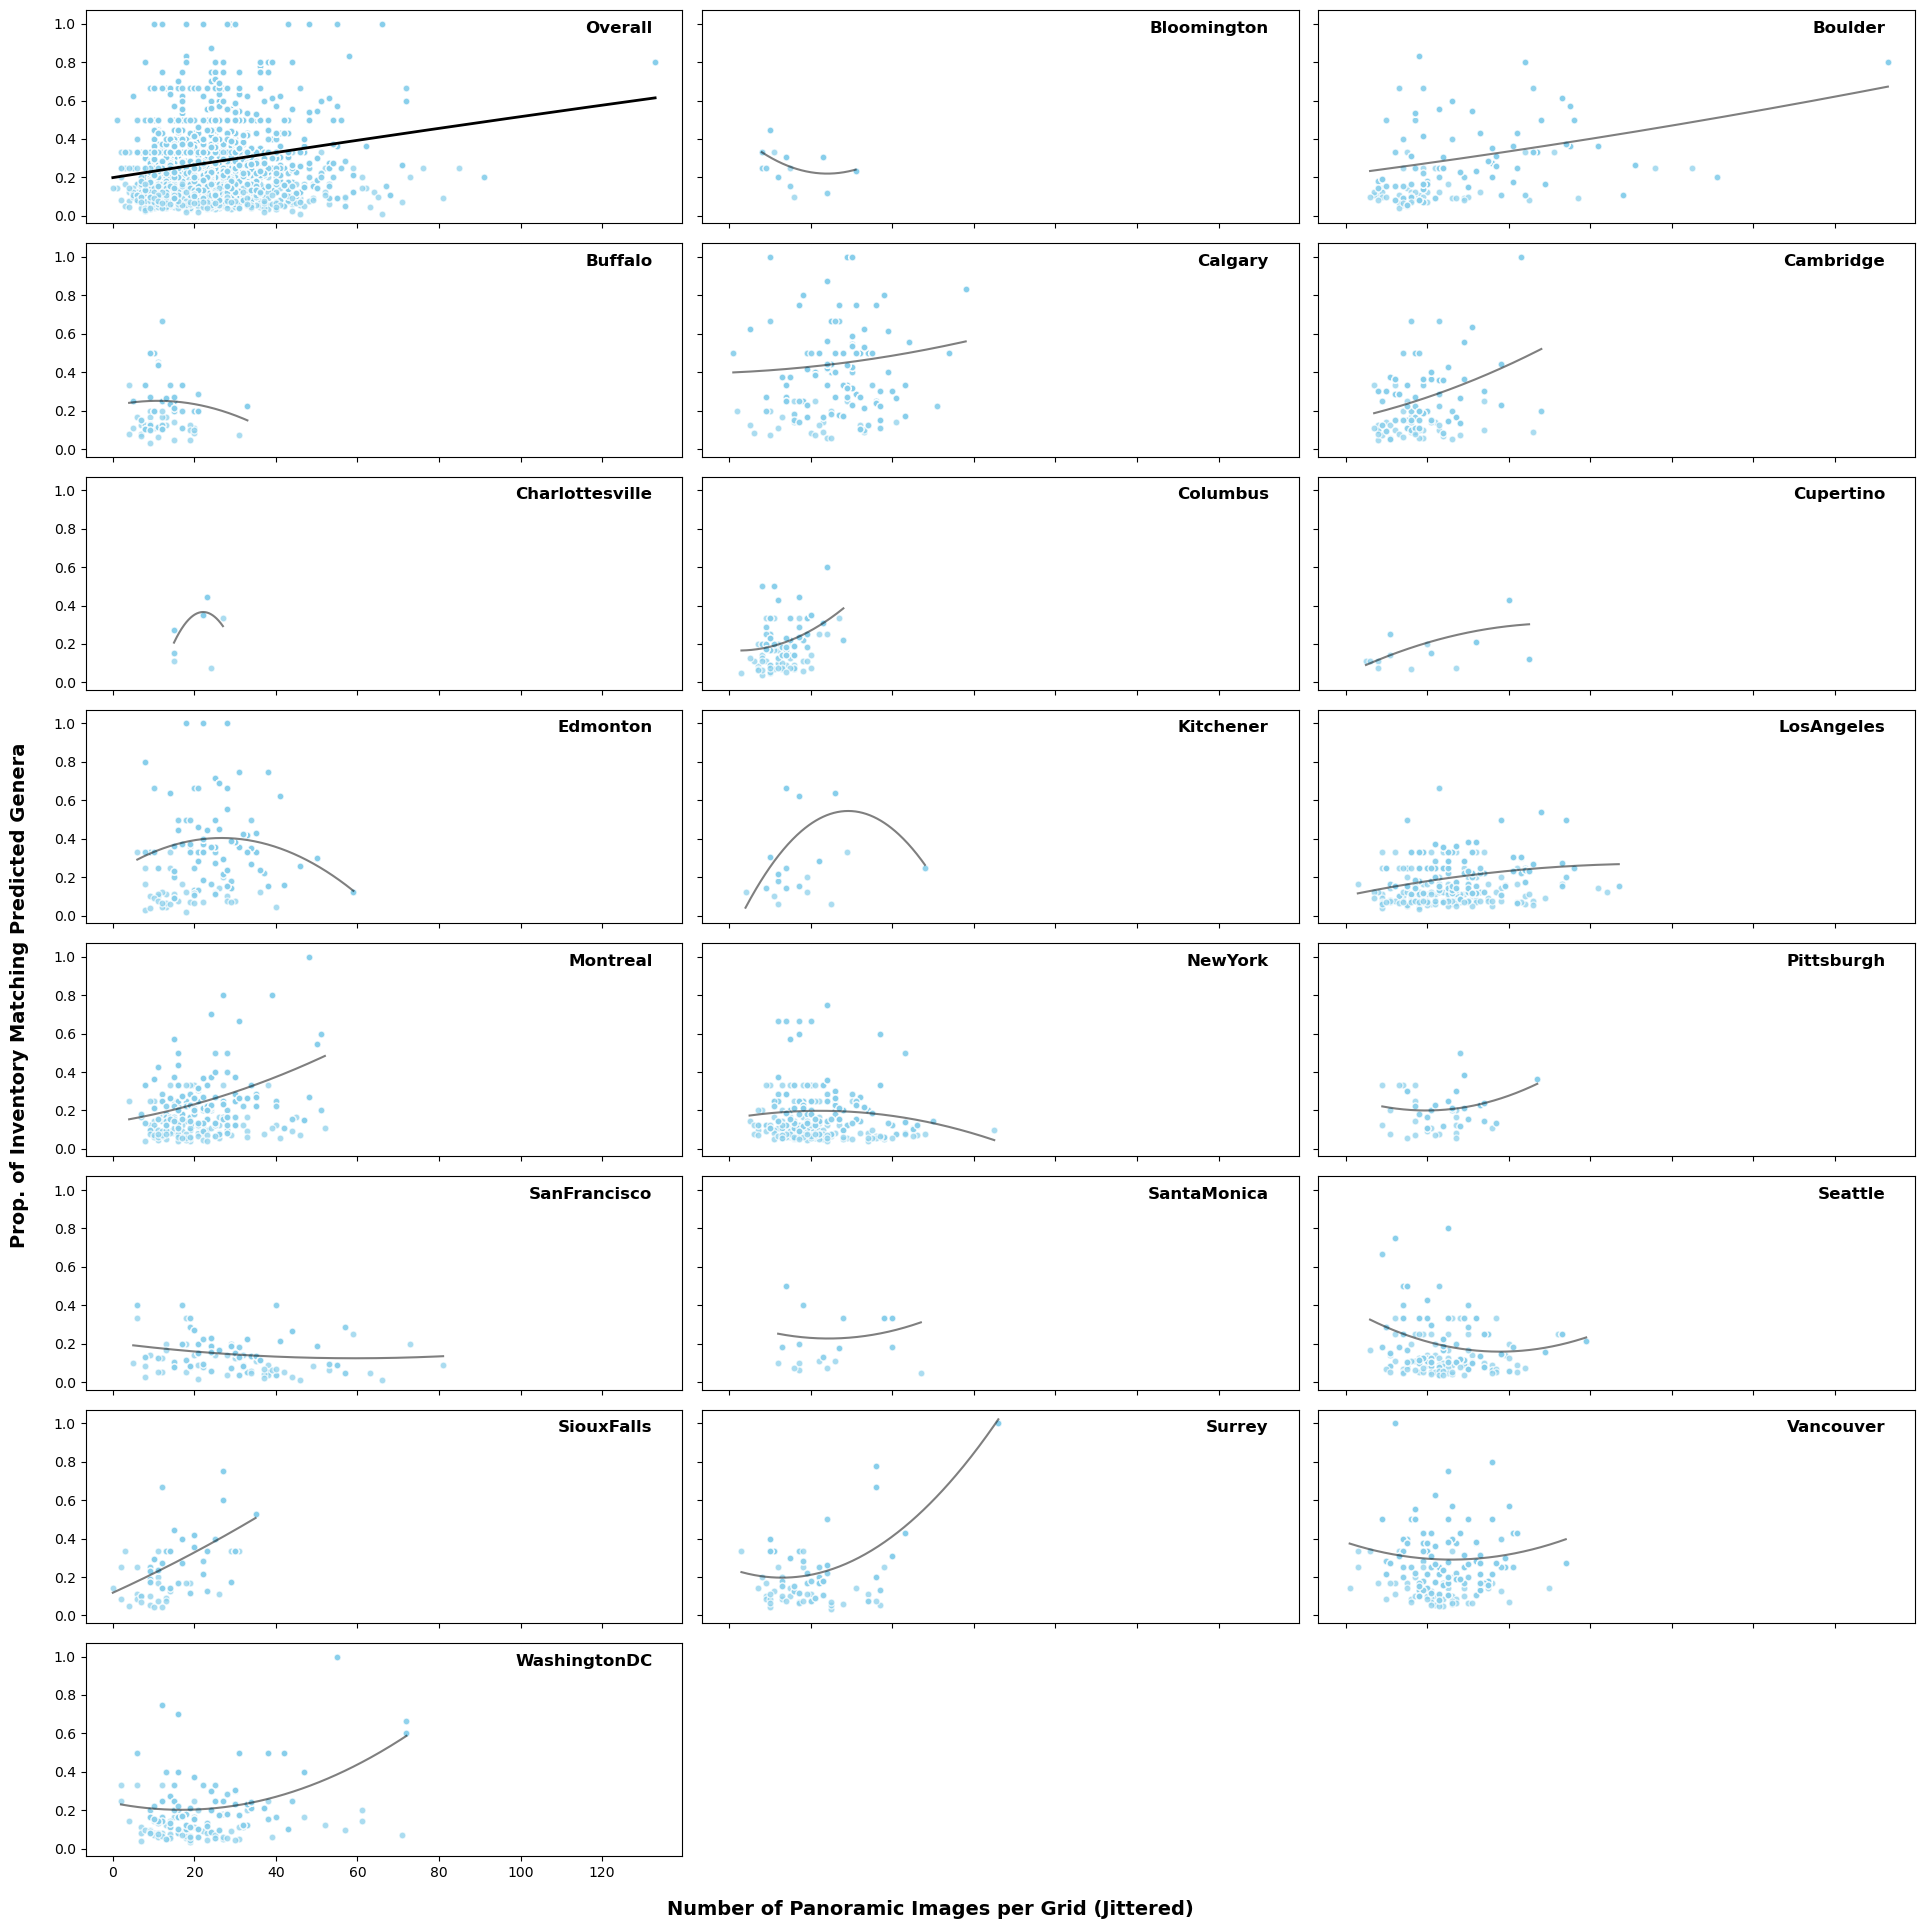

In [27]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

# Define linear and polynomial functions
def linear_func(x, m, c):
    return m * x + c

def poly_func(x, a, b, c):
    return a * x**2 + b * x + c

# Fit models and calculate RMSE
def fit_and_evaluate(x, y):
    # Fit linear model
    popt_linear, _ = curve_fit(linear_func, x, y)
    y_pred_linear = linear_func(x, *popt_linear)
    rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
    
    # Fit polynomial model
    popt_poly, _ = curve_fit(poly_func, x, y)
    y_pred_poly = poly_func(x, *popt_poly)
    rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
    
    return (popt_linear, rmse_linear), (popt_poly, rmse_poly)

# Fit and evaluate models for overall data
overall_linear, overall_poly = fit_and_evaluate(df['grid_num_panos'], df['proportion_matches'])

# Determine the best overall fit
best_overall_fit = overall_linear if overall_linear[1] < overall_poly[1] else overall_poly
best_overall_func = linear_func if overall_linear[1] < overall_poly[1] else poly_func

# Fit and evaluate models for each city
city_fits = {}
for city, group in df.groupby('All_Cities'):
    linear_fit, poly_fit = fit_and_evaluate(group['grid_num_panos'], group['proportion_matches'])
    best_fit = linear_fit if linear_fit[1] < poly_fit[1] else poly_fit
    city_fits[city] = best_fit

# Plot overall and per city subplots with best fit trendline
total_plots = len(city_fits) + 1
rows = (total_plots // 3) + (1 if total_plots % 3 != 0 else 0)

fig, axes = plt.subplots(rows, 3, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Plot overall in the first subplot
x_fit_overall = np.linspace(df['grid_num_panos'].min(), df['grid_num_panos'].max(), 200)
y_fit_overall = best_overall_func(x_fit_overall, *best_overall_fit[0])

axes[0].plot(x_fit_overall, y_fit_overall, color='black', linewidth=2, label="Overall")
axes[0].scatter(df['grid_num_panos'], df['proportion_matches'], color='skyblue', edgecolors='white', alpha=0.7, s=25)
axes[0].text(0.95, 0.95, "Overall", fontsize=12, fontweight="bold", transform=axes[0].transAxes, ha="right", va="top")

# Plot each city
for i, (city, group) in enumerate(df.groupby('All_Cities'), start=1):
    x_fit_city = np.linspace(group['grid_num_panos'].min(), group['grid_num_panos'].max(), 200)
    best_fit_func = linear_func if city_fits[city][1] < city_fits[city][1] else poly_func
    y_fit_city = best_fit_func(x_fit_city, *city_fits[city][0])
    axes[i].scatter(group['grid_num_panos'], group['proportion_matches'], color='skyblue', edgecolors='white', alpha=0.7, s=25)
    axes[i].plot(x_fit_city, y_fit_city, color='black', linewidth=1.5, alpha=0.5)
    axes[i].text(0.95, 0.95, city, fontsize=12, fontweight="bold", transform=axes[i].transAxes, ha="right", va="top")

# Hide unused subplots
for j in range(total_plots, len(axes)):
    fig.delaxes(axes[j])

# Add shared x and y axis labels
fig.text(0.5, 0.04, 'Number of Panoramic Images per Grid (Jittered)', ha='center', fontsize=14, fontweight='bold')
fig.text(0.04, 0.5, 'Prop. of Inventory Matching Predicted Genera', va='center', rotation='vertical', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

# Save and show the plot
#output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/all_cities_facet_plot_prop_matches_grid_num_panos.png'
#plt.savefig(output_path, dpi=300, bbox_inches="tight", format="png")
plt.show()

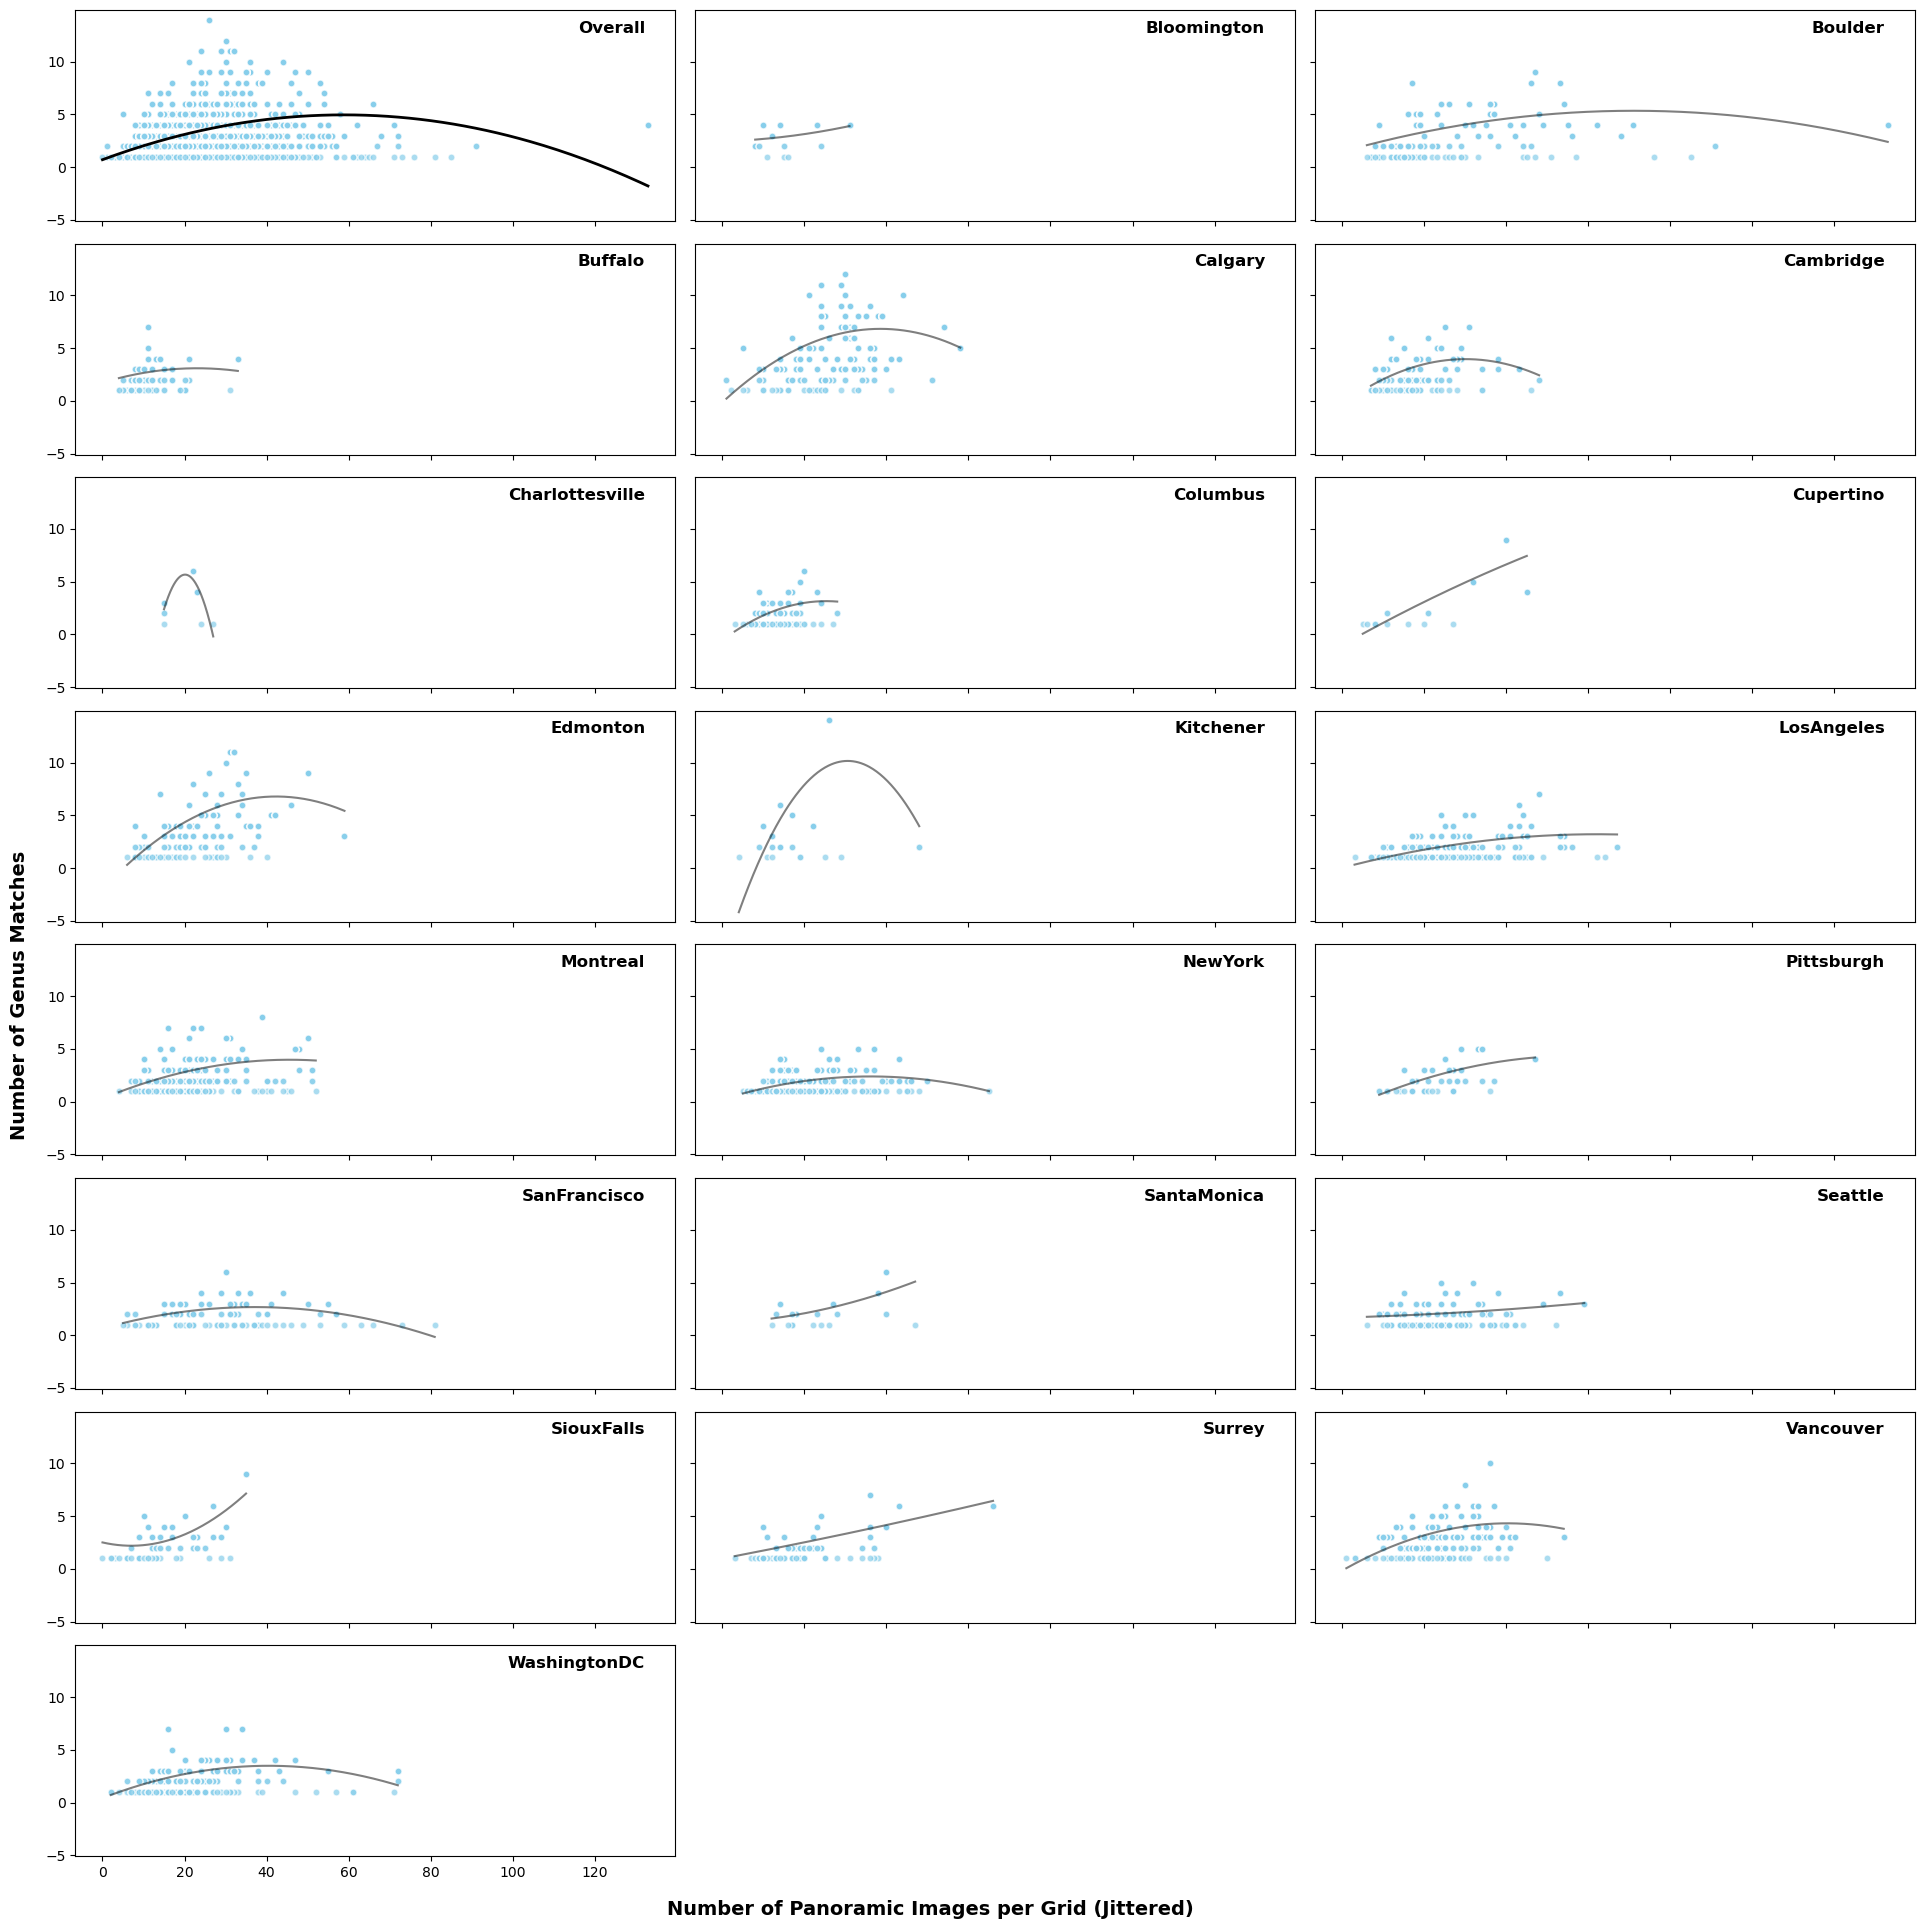

In [28]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

# Define linear and polynomial functions
def linear_func(x, m, c):
  return m * x + c

def poly_func(x, a, b, c):
  return a * x**2 + b * x + c

# Fit models and calculate RMSE
def fit_and_evaluate(x, y):
  # Fit linear model
  popt_linear, _ = curve_fit(linear_func, x, y)
  y_pred_linear = linear_func(x, *popt_linear)
  rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
  
  # Fit polynomial model
  popt_poly, _ = curve_fit(poly_func, x, y)
  y_pred_poly = poly_func(x, *popt_poly)
  rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
  
  return (popt_linear, rmse_linear), (popt_poly, rmse_poly)

# Fit and evaluate models for overall data
overall_linear, overall_poly = fit_and_evaluate(df['grid_num_panos'], df['num_genus_matches'])

# Determine the best overall fit
best_overall_fit = overall_linear if overall_linear[1] < overall_poly[1] else overall_poly
best_overall_func = linear_func if overall_linear[1] < overall_poly[1] else poly_func

# Fit and evaluate models for each city
city_fits = {}
for city, group in df.groupby('All_Cities'):
  linear_fit, poly_fit = fit_and_evaluate(group['grid_num_panos'], group['num_genus_matches'])
  best_fit = linear_fit if linear_fit[1] < poly_fit[1] else poly_fit
  city_fits[city] = best_fit

# Plot overall and per city subplots with best fit trendline
total_plots = len(city_fits) + 1
rows = (total_plots // 3) + (1 if total_plots % 3 != 0 else 0)

fig, axes = plt.subplots(rows, 3, figsize=(20, 20), sharex=True, sharey=True)
axes = axes.flatten()

# Plot overall in the first subplot
x_fit_overall = np.linspace(df['grid_num_panos'].min(), df['grid_num_panos'].max(), 200)
y_fit_overall = best_overall_func(x_fit_overall, *best_overall_fit[0])

axes[0].plot(x_fit_overall, y_fit_overall, color='black', linewidth=2, label="Overall")
axes[0].scatter(df['grid_num_panos'], df['num_genus_matches'], color='skyblue', edgecolors='white', alpha=0.7, s=25)
axes[0].text(0.95, 0.95, "Overall", fontsize=12, fontweight="bold", transform=axes[0].transAxes, ha="right", va="top")

# Plot each city
for i, (city, group) in enumerate(df.groupby('All_Cities'), start=1):
  x_fit_city = np.linspace(group['grid_num_panos'].min(), group['grid_num_panos'].max(), 200)
  best_fit_func = linear_func if city_fits[city][1] < city_fits[city][1] else poly_func
  y_fit_city = best_fit_func(x_fit_city, *city_fits[city][0])
  axes[i].scatter(group['grid_num_panos'], group['num_genus_matches'], color='skyblue', edgecolors='white', alpha=0.7, s=25)
  axes[i].plot(x_fit_city, y_fit_city, color='black', linewidth=1.5, alpha=0.5)
  axes[i].text(0.95, 0.95, city, fontsize=12, fontweight="bold", transform=axes[i].transAxes, ha="right", va="top")

# Hide unused subplots
for j in range(total_plots, len(axes)):
  fig.delaxes(axes[j])

# Add shared x and y axis labels
fig.text(0.5, 0.04, 'Number of Panoramic Images per Grid (Jittered)', ha='center', fontsize=14, fontweight='bold')
fig.text(0.04, 0.5, 'Number of Genus Matches', va='center', rotation='vertical', fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.05, 0.05, 1, 1])

# Save and show the plot
#output_path = '/Users/spwitz/Desktop/tree-geolocation-exp/all_city_geolocation_results_greedy_matching_tables_figures/all_cities_facet_plot_num_genus_matches_grid_num_panos.png'
#plt.savefig(output_path, dpi=300, bbox_inches="tight", format="png")
plt.show()